<a href="https://colab.research.google.com/github/GhBlg/Others/blob/main/sweeps_with_blocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Imports

In [1]:
!pip install wandb
!pip install scipy -U
!wandb login acf4cf1e91a5b92ebf1613195d6d05c09db63b4e
import math
import numpy as np
from math import ceil
import wandb
from torch import optim
import torch.nn.functional as F
from sklearn.metrics import f1_score
import torch
from torch import nn
from torch.nn import init
from torch.nn.utils import weight_norm
%matplotlib 
import matplotlib.pyplot as plt
import os
from google.colab import drive
drive.mount('/content/drive/')
import sys
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks/mne_data')
sys.path.append(os.path.abspath('/content/drive/MyDrive/Colab Notebooks/mne_data'))
!mkdir /content/resultdir
!pip install torchinfo
from torchinfo import summary
resultdir='/content/resultdir'
!pip install braindecode
!pip install tqdm
!pip install mne
!pip install moabb

###########     REPRODUCIBILITY      #######################################
random_seed=42
#torch.use_deterministic_algorithms(True)
torch.manual_seed(random_seed)
############################################################################

############################################################################

cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it (will take the gpu specified by the argument args.device)
device = 'cuda' if cuda else 'cpu'
os.makedirs(resultdir,exist_ok=True)
print(f"Will use device {device}")
print(f"Will save checkpoints to {resultdir}")
################################################################################################################################# 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Using matplotlib backend: agg
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
mkdir: cannot create directory ‘/content/resultdir’: File exists
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Will use d

###Utils

In [21]:
import numpy as np
import torch
# Import necessary library
from scipy.linalg import sqrtm, inv 
import numpy as np
from braindecode.datasets.moabb import MOABBDataset
from braindecode.datautil.windowers import create_windows_from_events


def resample(eeg):
    secs = eeg.shape[-1]/250.0 # from 250 Hz
    samps = int(secs*125)     # to 125 Hz
    eeg2 = torch.nn.functional.interpolate(eeg, size=samps)
    return eeg2


## Dataloader ###
def loaders(removed_subject,T_x,T_y,V_x,V_y,Test_x,Test_y,batch_size):
    train_data = list(zip(T_x, T_y))
    train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size)#, shuffle = True)
    valid_data = list(zip(V_x, V_y))
    valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size)#, shuffle = True)
    test_loader = torch.utils.data.DataLoader(list(zip(Test_x, Test_y)), batch_size = 10000)
    return train_loader, valid_loader, test_loader


# Apply Euclidean Alignment
def apply_EA(data, device='cuda'):
    '''
    Apply Euclidean aligment on array-like objects for 1 subject
    
    PARAMETER:
    data: 
        Data of one subject.
    
    
    OUTPUT:
        Aligned data with Euclidean Alignment
    '''
    
    # So that this function can handles separated or combined left and right trials
    # If they are separated
    # If they are not separated

    #if input is a torch tensor
    if torch.is_tensor(data):
        data=data.cpu().detach().numpy() 

    print('Found %d trial(s) in which EEG data is stored' %len(data))
    all_trials = data
    
    # Calculate reference matrix
    RefEA = 0
    print('Computing reference matrix RefEA')

    # Iterate over all trials, compute reference EA
    for trial in all_trials:
        cov = np.cov(trial, rowvar=True)
        RefEA += cov

    # Average over all trials
    RefEA = RefEA/all_trials.shape[0]
    
    # Adding reference EA as a new key in data
    data_dict={}
    print('Add RefEA as a new key in data')
    data_dict['RefEA'] = RefEA 
    
    # Compute R^(-0.5)
    R_inv = sqrtm(inv(RefEA))
    data_dict['R_inv'] = R_inv
    
        
    # Perform EA on each trial
    all_trials_EA = []
        
    for t in all_trials:
        all_trials_EA.append(R_inv@t)
        
    # Return all_trials_EA
    return torch.tensor(np.array(all_trials_EA)).float()
        

def standardize(X, mean=None, std=None):
  mean = X.mean(dim=-1, keepdim=True)
  std = X.std(dim=-1, keepdim=True)
  return (X - mean) / std , mean, std



################### Load Physionet data as done in the TIDNet paper ###################################################################
################## calling load_eeg_bci will return an object having data[subjects][records][0/1] 0 for Xs and 1 for Ys ###############
from torch.utils.data import Dataset
from mne.datasets import eegbci
import mne 
import tqdm
from collections import OrderedDict

BAD_SUBJECTS_EEGBCI = [87, 89, 91, 99]
SUBJECTS_EEGBCI = list(i for i in range(109) if i not in BAD_SUBJECTS_EEGBCI)
EVENTS_EEGBCI = dict(hands=2, feet=3)
BASELINE_EYES_OPEN = [1]
BASELINE_EYES_CLOSED = [2]

MOTOR_FISTS = (3, 7, 11)
IMAGERY_FISTS = (4, 8, 12)
MOTOR_FEET = (5, 9, 13)
IMAGERY_FEET_V_FISTS = (6, 10, 14)

def zscore(data: np.ndarray, axis=-1):
    return (data - data.mean(axis, keepdims=True)) / (data.std(axis, keepdims=True) + 1e-12)


def one_hot(y: torch.Tensor, num_classes):
    """ 1-hot encodes a tensor to another similarly stored tensor"""
    if len(y.shape) > 0 and y.shape[-1] == 1:
        y = y.squeeze(-1)
    out = torch.zeros(y.size()+torch.Size([num_classes]), device=y.device)
    return out.scatter_(-1, y.view((*y.size(), 1)), 1)

class EpochsDataset(Dataset):

    def __init__(self, epochs: mne.Epochs, force_label=None, picks=None, preproccesors=None, normalizer=zscore,
                 runs=None, train_mode=False):
        self.mode = train_mode
        self.epochs = epochs
        self._t_len = epochs.tmax - epochs.tmin
        self.loaded_x = [None for _ in range(len(epochs.events))]
        self.runs = runs
        self.picks = picks
        self.force_label = force_label if force_label is None else torch.tensor(force_label)
        self.normalizer = normalizer
        self.preprocessors = preproccesors if isinstance(preproccesors, (list, tuple)) else [preproccesors]
        for i, p in enumerate(self.preprocessors):
            self.preprocessors[i] = p(self.epochs)

    @property
    def channels(self):
        if self.picks is None:
            return len(self.epochs.ch_names)
        else:
            return len(self.picks)

    @property
    def sfreq(self):
        return self.epochs.info['sfreq']

    def train_mode(self, mode=False):
        self.mode = mode

    def __getitem__(self, index):
        ep = self.epochs[index]
        if self.loaded_x[index] is None:
            x = ep.get_data()
            if len(x.shape) != 3 or 0 in x.shape:
                print("I don't know why: {} index{}/{}".format(self.epochs, index, len(self)))
                print(self.epochs.info['description'])
                # raise AttributeError()
                return self.__getitem__(index - 1)
            x = x[0, self.picks, :]
            for p in self.preprocessors:
                x = p(x)
            x = torch.from_numpy(self.normalizer(x).astype('float32')).squeeze(0)
            self.loaded_x[index] = x
        else:
            x = self.loaded_x[index]

        y = torch.from_numpy(ep.events[..., -1]).long() if self.force_label is None else self.force_label

        if self.runs is not None:
            return x, y, one_hot(torch.tensor(self.runs * index / len(self)).long(), self.runs)

        return x, y

    def __len__(self):
        events = self.epochs.events[:, 0].tolist()
        return len(events)

def same(x):
    return x

def load_eeg_bci(targets=4, tmin=0, tlen=3, t_ev=0, t_sub=None, normalizer=same, low_f=None, high_f=None, #zscore
                 alignment=False, path_mne=None):

    paths = [eegbci.load_data(s+1, IMAGERY_FISTS, path=path_mne, update_path=False) for s in SUBJECTS_EEGBCI]
    raws = [mne.io.concatenate_raws([mne.io.read_raw_edf(p, preload=True) for p in path])
            for path in tqdm.tqdm(paths, unit='subj', desc='Loading')]
    datasets = OrderedDict()
    for i, raw in tqdm.tqdm(list(zip(SUBJECTS_EEGBCI, raws)), desc='Preprocessing'):
        if raw.info['sfreq'] != 160:
            tqdm.tqdm.write('Skipping..., sampling frequency: {}'.format(raw.info['sfreq']))
            continue
        raw.rename_channels(lambda x: x.strip('.'))
        if low_f or high_f:
            raw.filter(low_f, high_f, fir_design='firwin', skip_by_annotation='edge')
        events, _ = mne.events_from_annotations(raw, event_id=dict(T1=0, T2=1))
        picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')
        epochs = mne.Epochs(raw, events[:41, ...], tmin=tmin, tmax=tmin + tlen - 1 / raw.info['sfreq'], picks=picks,
                            baseline=None, reject_by_annotation=False)#.drop_bad()
        if targets > 2:
            paths = eegbci.load_data(i + 1, BASELINE_EYES_OPEN, path=path_mne, update_path=False)
            raw = mne.io.concatenate_raws([mne.io.read_raw_edf(p, preload=True) for p in paths])
            raw.rename_channels(lambda x: x.strip('.'))
            if low_f or high_f:
                raw.filter(low_f, high_f, fir_design='firwin', skip_by_annotation='edge')
            events = np.zeros((events.shape[0] // 2, 3)).astype('int')
            events[:, -1] = 2
            events[:, 0] = np.linspace(0, raw.info['sfreq'] * (60 - 2 * tlen), num=events.shape[0]).astype(np.int)
            picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')
            eyes_epochs = mne.Epochs(raw, events, tmin=tmin, tmax=tmin + tlen - 1 / raw.info['sfreq'], picks=picks,
                                     baseline=None, reject_by_annotation=False)#.drop_bad()
            epochs = mne.concatenate_epochs([eyes_epochs, epochs])
        if targets > 3:
            paths = eegbci.load_data(i+1, IMAGERY_FEET_V_FISTS, path=path_mne, update_path=False)
            raw = mne.io.concatenate_raws([mne.io.read_raw_edf(p, preload=True) for p in paths])
            raw.rename_channels(lambda x: x.strip('.'))
            if low_f or high_f:
                raw.filter(low_f, high_f, fir_design='firwin', skip_by_annotation='edge')
            events, _ = mne.events_from_annotations(raw, event_id=dict(T2=3))
            picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')
            feet_epochs = mne.Epochs(raw, events[:20, ...], tmin=tmin, tmax=tmin + tlen - 1 / raw.info['sfreq'],
                                     picks=picks, baseline=None, reject_by_annotation=False)#.drop_bad()
            epochs = mne.concatenate_epochs([epochs, feet_epochs])

        datasets[i] = EpochsDataset(epochs, preproccesors=EuclideanAlignment if alignment else [],
                                    normalizer=normalizer, runs=3)

    return datasets


####################################################################################################################



def load_subjects(path, number_of_subjects, device, bad_subjects=[], apply_euclidean=True, with_eog=True):
    l= number_of_subjects+1
    sbj_x=[]
    sbj_y=[]
    if number_of_subjects==9:
        for subject_id in [e for e in range(1,l) if e not in bad_subjects]:
            dataset = MOABBDataset(dataset_name="BNCI2014001", subject_ids=[subject_id])


            trial_start_offset_seconds = -0.5  #####################
            # Extract sampling frequency, check that they are same in all datasets
            sfreq = dataset.datasets[0].raw.info['sfreq']            
            trial_stop_offset_samples= int(0 * sfreq)  #######################

            assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])
            # Calculate the trial start offset in samples.
            trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

            # Create windows using braindecode function for this. It needs parameters to define how
            # trials should be used.
            windows_dataset = create_windows_from_events(
                dataset,
                trial_start_offset_samples=trial_start_offset_samples,
                trial_stop_offset_samples=trial_stop_offset_samples, 
                preload=True,
            )


            splitted = windows_dataset.split('session')
            train_set = splitted['session_T']
            valid_set = splitted['session_E']

            # delete stim channel and eog channels if wanted
            if with_eog==False: 
              dlt=-4
            else:
              dlt=-1

            train_x=np.array([ele[0][:dlt] for ele in train_set])
            train_y=np.array([ele[1] for ele in train_set])

            valid_x=np.array([ele[0][:dlt] for ele in valid_set])
            valid_y=np.array([ele[1] for ele in valid_set])

            T_x = torch.tensor( np.append(np.array(train_x), np.array(valid_x), axis=0) )
            T_y = torch.tensor( np.append(np.array(train_y), np.array(valid_y), axis=0) )

            #T_x=resample(T_x)############################# added to do downsampling

            if apply_euclidean==True:
                x=apply_EA(T_x)
            else : 
                x=T_x

            sbj_x.append(x)
            sbj_y.append(T_y)
            del T_x, T_y


    if number_of_subjects==52:
        for subject_id in [e for e in range(1,l) if e not in bad_subjects]:
            dataset = MOABBDataset(dataset_name="Cho2017", subject_ids=[subject_id])


            trial_start_offset_seconds = -0.5  #####################
            # Extract sampling frequency, check that they are same in all datasets
            sfreq = dataset.datasets[0].raw.info['sfreq']            
            trial_stop_offset_samples= int(0 * sfreq)  #######################

            assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])
            # Calculate the trial start offset in samples.
            trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

            # Create windows using braindecode function for this. It needs parameters to define how
            # trials should be used.
            windows_dataset = create_windows_from_events(
                dataset,
                trial_start_offset_samples=trial_start_offset_samples,
                trial_stop_offset_samples=trial_stop_offset_samples, 
                preload=True,
            )


            splitted = windows_dataset.split('session')
            splits = splitted['session_0']

            # delete stim channel and EMG channels and EOG if wanted 
            if with_eog==False: 
              ch=dataset.datasets[0].raw.ch_names
              no_eog=[e for e in range(len(ch)) if e not in [ch.index('Fp1'),ch.index('Fp2'),ch.index('Fpz'),64, 65, 66, 67, 68]]
              T_x=np.array([ele[0][no_eog] for ele in splits])
              T_y=np.array([ele[1] for ele in splits])
            else:
              dlt=-5
              T_x=np.array([ele[0][:dlt] for ele in splits])
              T_y=np.array([ele[1] for ele in splits])

            T_x = torch.tensor(T_x)
            T_y = torch.tensor(T_y)

            if apply_euclidean==True:
                x=apply_EA(T_x)
            else : 
                x=T_x

            sbj_x.append(x)
            sbj_y.append(T_y)
            del T_x, T_y


    elif number_of_subjects==109:
        bad_subjects=[s-1 for s in bad_subjects]
        data=load_eeg_bci(path_mne=path)
        for subject_id in [e for e in range(number_of_subjects) if e not in bad_subjects]:   
            xx=[]
            yy=[]
            for records in range(len(data[subject_id])):
                xx.append(data[subject_id][records][0])
                yy.append(data[subject_id][records][1])
            xx=torch.stack(xx)
            yy=torch.tensor(yy)
            if apply_euclidean==True:
                sbj_x.append(apply_EA(xx))
            else:
                sbj_x.append(xx)
            sbj_y.append(yy)

    return sbj_x, sbj_y



#################### Leave One Subject Out ############################
def loso(x, y, number_of_subjects, loso, device, bad_subjects=[], with_validation=True): 
    l= number_of_subjects
    [s-1 for s in bad_subjects]
    T_x=torch.tensor([])
    T_y=torch.tensor([])

    loso=loso-1 # because lists start from 0

    for subject_id in [e for e in range(l) if e not in [loso]+bad_subjects]:
        T_x=torch.cat((T_x,x[subject_id]), 0)
        T_y=torch.cat((T_y,y[subject_id]), 0)

    T_x=torch.tensor(T_x).reshape([-1, T_x.shape[1], T_x.shape[2]])
    T_y=torch.tensor(T_y).reshape([-1])

    k_f=int(0.9*T_x.shape[0])

    if with_validation==True:
        data_perm = torch.randperm(T_x.shape[0])
        temp_x, temp_y = T_x[data_perm[:]], T_y[data_perm[:]]
        T_x, T_y = temp_x[:k_f], temp_y[:k_f]
        V_x, V_y = temp_x[k_f:], temp_y[k_f:]
    else :
        V_x, V_y = torch.tensor([]), torch.tensor([])


    Test_x=x[loso]
    Test_y=y[loso]

    
    T_x, mean, std=standardize(T_x)
    if with_validation==True:
        V_x, _ , _=standardize(V_x,mean, std)
    Test_x, _ , _=standardize(Test_x, mean, std)

    ############################################################################
    return(T_x.to(device).nan_to_num(),T_y.to(device).to(torch.int64),V_x.to(device).nan_to_num(),V_y.to(device).to(torch.int64),Test_x.to(device).nan_to_num(),Test_y.to(device).to(torch.int64))


#################### Leave Multiple Subjects Out ############################
import random
from sklearn.model_selection import KFold

def lmso(x, y, number_of_subjects, kfold, device, bad_subjects=[], with_validation=True, random_seed=42): 
    c = list(zip(x, y))
    random.Random(random_seed).shuffle(c)
    x, y = zip(*c)
    
    # 10-fold crossvalidation
    kf = KFold(n_splits=10)

    x=np.array([t.numpy() for t in x])
    y=np.array([t.numpy() for t in y])


    i=1
    for train_index, test_index in kf.split(x):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        if i==kfold:
            break
        else:
            i+=1
    

    del c, kf

    l= number_of_subjects
    [s-1 for s in bad_subjects]

    T_x=torch.tensor([])
    T_y=torch.tensor([])
    Test_x=torch.tensor([])
    Test_y=torch.tensor([])

    for subject_id in [e for e in range(X_train.shape[0])]:
        T_x=torch.cat((T_x,torch.tensor(X_train[subject_id])), 0)
        T_y=torch.cat((T_y,torch.tensor(y_train[subject_id])), 0)

    T_x=torch.tensor(T_x).reshape([-1, T_x.shape[1], T_x.shape[2]])
    T_y=torch.tensor(T_y).reshape([-1])

    k_f=int(0.9*T_x.shape[0])

    if with_validation==True:
        data_perm = torch.randperm(T_x.shape[0])
        temp_x, temp_y = T_x[data_perm[:]], T_y[data_perm[:]]
        T_x, T_y = temp_x[:k_f], temp_y[:k_f]
        V_x, V_y = temp_x[k_f:], temp_y[k_f:]
    else :
        V_x, V_y = torch.tensor([]), torch.tensor([])

    for lms in range(len(X_test)):
        Test_x=torch.cat((Test_x,torch.tensor(X_test[lms])), 0)
        Test_y=torch.cat((Test_y,torch.tensor(y_test[lms])), 0)

    Test_x=torch.tensor(Test_x).reshape([-1, Test_x.shape[1], Test_x.shape[2]])
    Test_y=torch.tensor(Test_y).reshape([-1])
    
    T_x, mean, std=standardize(T_x)
    if with_validation==True:
        V_x, _ , _=standardize(V_x,mean, std)
    Test_x, _ , _=standardize(Test_x, mean, std)
    
    ############################################################################
    return(T_x.to(device).nan_to_num(),T_y.to(device).to(torch.int64),V_x.to(device).nan_to_num(),V_y.to(device).to(torch.int64),Test_x.to(device).nan_to_num(),Test_y.to(device).to(torch.int64))


#############Data Augmentation ###########################################################
from scipy.signal import butter, lfilter
from random import gauss
import numpy as np
import math
from matplotlib import pyplot

#add noise
def chua(n):
    alpha  = 15.6
    beta   = 31
    m0     = -1.143
    m1     = -0.714

    x=0.7
    y=0
    z=0

    dt=0.01

    sig=[]
    sig1=[]

    for i in range(n):
        
        phi=m1*x+0.5*(m0-m1)*(abs(x+1)-abs(x-1))
        x1=alpha*(y-x-phi)
        y1=x-y+z
        z1=-beta*y

        
        x=x1*dt+x
        y=y1*dt+y
        z=z1*dt+z

        sig.append(x)
        sig1.append(y)

    return sig

def SNR_Set(Signal, Desired_SNR_dB):
    Npts = len(Signal)
    #Gaussian Noise
##    Noise = [gauss(0.0, 1.0) for i in range(Npts)] # Generate initial noise;
##                                                #mean zero, variance one
    #Poisson noise
    Noise = np.random.poisson(5, Npts)


    #Chaotic noise (chua model)
    #Noise = chua(Npts)


    
    Signal_Power = sum(abs(Signal)*abs(Signal))/Npts
    absN=[abs(i) for i in Noise]
    absnsqrd=[i*i for i in absN]
    Noise_Power = sum(absnsqrd)/Npts
            

    K = (Signal_Power/Noise_Power)*10**(-Desired_SNR_dB/10)  

    New_Noise = [math.sqrt(K)*i for i in Noise]

    Noisy_Signal = Signal + New_Noise
    return Noisy_Signal

#flip channels
def flip_channels(data):
  r=torch.randperm(data.shape[1])
  data=data[:,r,:]
  return data

#time inverse
def time_inverse(data):
  return torch.flip(data, [2])

#Masking in %
def masking(data,p):
  x=data
  mask=torch.FloatTensor(x.shape).uniform_() > p
  masked_output = data * mask.int().float().to(device)
  return masked_output


def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

selection=['fc','ti','mask','filter']
def apply_da(data,selection):
  s=random.choice(selection)
  if s=='fc':
    data=flip_channels(data)
  elif s=='ti':
    data=time_inverse(data)
  elif s=='mask':
    data=masking(data,0.2)
  elif s=='filter':
    data=torch.tensor(butter_bandpass_filter(data.detach().cpu().numpy(),0.1, 40, 250)).float().to(device)
  return data

#####################################################################################

def weight_attack(model, p=0.1):
  ii=0
  for i in model:
    try:
      r1=torch.max(model[ii].weight)
      r2=torch.min(model[ii].weight)
      M1=(r1 - r2) * torch.rand(model[ii].weight.shape)+ r2
      M2=(torch.abs(M1)< p*(r1 - r2)).float()
      with torch.no_grad():
        M1=torch.flatten(M1)
        M2=torch.flatten(M2)
        mw=torch.flatten(model[2].weight)
        shp=model[ii].weight.shape
        for i in range(len(M1)):
          if M2[i]==1:
            mw[i]=M1[i]
        mw=mw.double()

        model[ii].weight=torch.nn.Parameter(mw.reshape(shp))
    except:
      pass
    ii+=1
  return model


#####################################################################################

############### Create Adjacency matrix ######################

def build_edge_idx_full_graph(num_nodes):
    
    # Creation of the adjacency matrix of a fully connected graph

    # Initialization of edge index matrix
    E = torch.zeros((2, num_nodes * (num_nodes - 1)), dtype=torch.long)
    
    # Populate 1st row
    for node in range(num_nodes):
        for neighbor in range(num_nodes - 1):
            E[0, node * (num_nodes - 1) + neighbor] = node

    # Populate 2nd row
    neighbors = []
    for node in range(num_nodes):
        neighbors.append(list(np.arange(node)) + list(np.arange(node+1, num_nodes)))
    E[1, :] = torch.as_tensor([item for sublist in neighbors for item in sublist])
    
    return E


import mne
from scipy.spatial import distance
import networkx as nx
def masking(x,number_of_subjects,masking_type,channels,neighbours=0,time_steps=0.5,window_start=0):

  #delete the neighbours using the specified technique
  if masking_type[:4]=='temp':
    sfreq=dataset.datasets[0].raw.info['sfreq']
    assert x[0].shape[2]-(window_start+int(time_steps*sfreq))>=0 , "Oh no! This assertion failed!"
    
    for i in range(len(x)):
      for j in range(x[i].shape[2]):
        if j not in range( int(window_start*sfreq), int(window_start*sfreq+time_steps*sfreq) ):
          x[i][:,:,j]=0
  
  elif masking_type[:4]=='freq':
    v=masking_type[-1]
    sfreq=dataset.datasets[0].raw.info['sfreq']
    if v=='a':
      filt=[8, 12]
    elif v=='b':
      filt=[12, 24]
    elif v=='t':
      filt=[4, 8]
    elif v=='g':
      filt=[32, int((sfreq-1)/2)]
    elif v=='d':
      filt=[0.1, 4]
    for i in range(len(x)):
      x[i]=torch.tensor(butter_bandpass_filter(x[i].detach().cpu().numpy(),filt[0], filt[1], sfreq)).float()
  
  #order channels and create the channel graph (if spatial masking)
  else:
    E=build_edge_idx_full_graph(len(channels)).long()
    index=channels.index(masking_type)
    #No neighbours
    if neighbours==0:
      for i in range(len(x)):
        x[i][:,index,:]=torch.zeros(x[i].shape[2])
    #1 neighbours
    else:
      tt = mne.channels.make_standard_montage('standard_1020')
      pos=[]
      for c in channels:
          pos.append(tt.get_positions()['ch_pos'][c])
      pos=np.array(pos)    
      #### distances
      distances=[]
      for i in range(len(E[0])) :
              distances.append(distance.euclidean(pos[E[0,i]], pos[E[1,i]]))
      distances=np.array(distances)
      ### new edges with THRESHOLD 
      threshold=0.4*distances.mean() ################# ---> THRESHOLD 
      dele=[]
      for i in range(len(E[0])) :
              if distance.euclidean(pos[E[0,i]], pos[E[1,i]])>threshold :
                  dele.append(i)
      E=np.delete(E,dele,1)
      E=torch.transpose(E, 0, 1)
      to_del=[]
      for i in range(E.shape[0]):
        if index in E[i]:
          to_del.append(E[i][0])
          to_del.append(E[i][1])
      to_del=torch.unique(torch.tensor(to_del))
      
      for i in range(len(x)):
        for j in to_del:
          x[i][:,j,:]=torch.zeros(x[i].shape[2])


  #merge the masking into the data
  return x

In [42]:
#number_of_subjects=9
#bad_subjects=[] #bad subject for Physionet MI
#x1, y1= load_subjects('/content/drive/MyDrive/Colab Notebooks/', number_of_subjects, device, bad_subjects, apply_euclidean=True, with_eog=True) 

number_of_subjects=109
bad_subjects=[88,90,92,100] #bad subject for Physionet MI
x2, y2= load_subjects('/content/drive/MyDrive/Colab Notebooks/', number_of_subjects, device, bad_subjects, apply_euclidean=True, with_eog=True) 

#number_of_subjects=52
#bad_subjects=[32,46,49] #bad subject for Cho2017
#x3, y3= load_subjects('/content/drive/MyDrive/Colab Notebooks/', number_of_subjects, device, bad_subjects, apply_euclidean=True, with_eog=True) 



Loading:   0%|          | 0/105 [00:00<?, ?subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


Loading:   1%|          | 1/105 [00:00<00:17,  5.95subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:   2%|▏         | 2/105 [00:00<00:17,  5.98subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


Loading:   3%|▎         | 3/105 [00:00<00:16,  6.19subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:   4%|▍         | 4/105 [00:00<00:15,  6.40subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:   5%|▍         | 5/105 [00:00<00:15,  6.32subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S006/S006R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S006/S006R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S006/S006R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:   6%|▌         | 6/105 [00:00<00:15,  6.36subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


Loading:   7%|▋         | 7/105 [00:01<00:15,  6.37subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S008/S008R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S008/S008R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S008/S008R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:   8%|▊         | 8/105 [00:01<00:15,  6.39subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S009/S009R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S009/S009R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S009/S009R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:   9%|▊         | 9/105 [00:01<00:14,  6.43subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S010/S010R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S010/S010R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S010/S010R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  10%|▉         | 10/105 [00:01<00:14,  6.36subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S011/S011R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S011/S011R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S011/S011R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  10%|█         | 11/105 [00:01<00:14,  6.43subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S012/S012R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S012/S012R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S012/S012R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  11%|█▏        | 12/105 [00:01<00:14,  6.54subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S013/S013R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S013/S013R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S013/S013R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  12%|█▏        | 13/105 [00:02<00:13,  6.76subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S014/S014R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S014/S014R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S014/S014R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  13%|█▎        | 14/105 [00:02<00:13,  6.96subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S015/S015R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S015/S015R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S015/S015R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  14%|█▍        | 15/105 [00:02<00:13,  6.89subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S016/S016R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S016/S016R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S016/S016R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  15%|█▌        | 16/105 [00:02<00:13,  6.76subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S017/S017R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S017/S017R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S017/S017R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  16%|█▌        | 17/105 [00:02<00:13,  6.58subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S018/S018R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S018/S018R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S018/S018R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  17%|█▋        | 18/105 [00:02<00:13,  6.49subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S019/S019R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S019/S019R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S019/S019R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  18%|█▊        | 19/105 [00:02<00:13,  6.48subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S020/S020R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S020/S020R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S020/S020R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  19%|█▉        | 20/105 [00:03<00:13,  6.41subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S021/S021R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S021/S021R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S021/S021R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


Loading:  20%|██        | 21/105 [00:03<00:13,  6.38subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S022/S022R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S022/S022R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S022/S022R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


Loading:  21%|██        | 22/105 [00:03<00:13,  6.38subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S023/S023R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S023/S023R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S023/S023R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  22%|██▏       | 23/105 [00:03<00:12,  6.57subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S024/S024R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S024/S024R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S024/S024R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  23%|██▎       | 24/105 [00:03<00:11,  6.76subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S025/S025R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S025/S025R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S025/S025R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  24%|██▍       | 25/105 [00:03<00:11,  6.93subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S026/S026R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S026/S026R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S026/S026R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  25%|██▍       | 26/105 [00:03<00:11,  7.09subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S027/S027R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S027/S027R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S027/S027R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  26%|██▌       | 27/105 [00:04<00:10,  7.18subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S028/S028R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S028/S028R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S028/S028R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  27%|██▋       | 28/105 [00:04<00:10,  7.26subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S029/S029R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S029/S029R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S029/S029R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...


Loading:  28%|██▊       | 29/105 [00:04<00:10,  7.18subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S030/S030R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S030/S030R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S030/S030R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...


Loading:  29%|██▊       | 30/105 [00:04<00:10,  7.17subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S031/S031R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S031/S031R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S031/S031R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  30%|██▉       | 31/105 [00:04<00:10,  7.17subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S032/S032R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S032/S032R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S032/S032R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


Loading:  30%|███       | 32/105 [00:04<00:10,  7.20subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S033/S033R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S033/S033R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S033/S033R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  31%|███▏      | 33/105 [00:04<00:09,  7.26subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S034/S034R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S034/S034R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S034/S034R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  32%|███▏      | 34/105 [00:05<00:09,  7.30subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S035/S035R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S035/S035R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S035/S035R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


Loading:  33%|███▎      | 35/105 [00:05<00:09,  7.05subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S036/S036R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S036/S036R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S036/S036R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  34%|███▍      | 36/105 [00:05<00:10,  6.84subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S037/S037R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S037/S037R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S037/S037R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  35%|███▌      | 37/105 [00:05<00:10,  6.69subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S038/S038R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S038/S038R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S038/S038R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  36%|███▌      | 38/105 [00:05<00:10,  6.52subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S039/S039R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S039/S039R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S039/S039R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  37%|███▋      | 39/105 [00:05<00:10,  6.37subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S040/S040R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S040/S040R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S040/S040R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  38%|███▊      | 40/105 [00:06<00:10,  6.35subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S041/S041R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S041/S041R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S041/S041R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...


Loading:  39%|███▉      | 41/105 [00:06<00:10,  6.20subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S042/S042R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S042/S042R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S042/S042R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  40%|████      | 42/105 [00:06<00:10,  6.26subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S043/S043R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S043/S043R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S043/S043R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  41%|████      | 43/105 [00:06<00:09,  6.26subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S044/S044R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S044/S044R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S044/S044R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  42%|████▏     | 44/105 [00:06<00:09,  6.19subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S045/S045R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S045/S045R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S045/S045R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  43%|████▎     | 45/105 [00:06<00:09,  6.22subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S046/S046R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S046/S046R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S046/S046R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


Loading:  44%|████▍     | 46/105 [00:06<00:09,  6.22subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S047/S047R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S047/S047R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S047/S047R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  45%|████▍     | 47/105 [00:07<00:09,  6.29subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S048/S048R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S048/S048R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S048/S048R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  46%|████▌     | 48/105 [00:07<00:09,  6.24subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S049/S049R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S049/S049R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S049/S049R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  47%|████▋     | 49/105 [00:07<00:08,  6.24subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S050/S050R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S050/S050R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S050/S050R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  48%|████▊     | 50/105 [00:07<00:08,  6.19subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S051/S051R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S051/S051R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S051/S051R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...


Loading:  49%|████▊     | 51/105 [00:07<00:08,  6.19subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S052/S052R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S052/S052R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S052/S052R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  50%|████▉     | 52/105 [00:07<00:08,  6.14subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S053/S053R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S053/S053R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S053/S053R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  50%|█████     | 53/105 [00:08<00:08,  6.17subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S054/S054R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S054/S054R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S054/S054R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  51%|█████▏    | 54/105 [00:08<00:08,  6.19subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S055/S055R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S055/S055R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S055/S055R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  52%|█████▏    | 55/105 [00:08<00:07,  6.28subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S056/S056R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S056/S056R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S056/S056R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  53%|█████▎    | 56/105 [00:08<00:07,  6.52subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S057/S057R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S057/S057R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S057/S057R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


Loading:  54%|█████▍    | 57/105 [00:08<00:07,  6.73subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S058/S058R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S058/S058R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S058/S058R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  55%|█████▌    | 58/105 [00:08<00:06,  6.82subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S059/S059R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S059/S059R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S059/S059R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  56%|█████▌    | 59/105 [00:08<00:06,  6.77subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S060/S060R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S060/S060R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S060/S060R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  57%|█████▋    | 60/105 [00:09<00:06,  6.72subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S061/S061R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S061/S061R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S061/S061R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


Loading:  58%|█████▊    | 61/105 [00:09<00:06,  6.64subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S062/S062R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S062/S062R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S062/S062R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  59%|█████▉    | 62/105 [00:09<00:06,  6.52subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S063/S063R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S063/S063R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S063/S063R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  60%|██████    | 63/105 [00:09<00:06,  6.45subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S064/S064R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S064/S064R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S064/S064R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  61%|██████    | 64/105 [00:09<00:06,  6.50subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S065/S065R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S065/S065R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S065/S065R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


Loading:  62%|██████▏   | 65/105 [00:09<00:06,  6.64subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S066/S066R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S066/S066R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S066/S066R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


Loading:  63%|██████▎   | 66/105 [00:10<00:05,  6.79subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S067/S067R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S067/S067R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S067/S067R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  64%|██████▍   | 67/105 [00:10<00:05,  6.85subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S068/S068R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S068/S068R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S068/S068R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  65%|██████▍   | 68/105 [00:10<00:05,  6.66subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S069/S069R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S069/S069R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S069/S069R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  66%|██████▌   | 69/105 [00:10<00:05,  6.57subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S070/S070R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S070/S070R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S070/S070R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  67%|██████▋   | 70/105 [00:10<00:05,  6.43subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S071/S071R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S071/S071R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S071/S071R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


Loading:  68%|██████▊   | 71/105 [00:10<00:05,  6.33subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S072/S072R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S072/S072R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S072/S072R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...


Loading:  69%|██████▊   | 72/105 [00:10<00:05,  6.30subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S073/S073R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S073/S073R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S073/S073R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  70%|██████▉   | 73/105 [00:11<00:05,  6.17subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S074/S074R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S074/S074R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S074/S074R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  70%|███████   | 74/105 [00:11<00:05,  6.02subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S075/S075R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S075/S075R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S075/S075R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  71%|███████▏  | 75/105 [00:11<00:05,  5.98subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S076/S076R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S076/S076R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S076/S076R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  72%|███████▏  | 76/105 [00:11<00:05,  5.78subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S077/S077R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S077/S077R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S077/S077R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  73%|███████▎  | 77/105 [00:11<00:04,  5.77subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S078/S078R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S078/S078R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S078/S078R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  74%|███████▍  | 78/105 [00:12<00:04,  5.79subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S079/S079R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S079/S079R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S079/S079R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


Loading:  75%|███████▌  | 79/105 [00:12<00:04,  5.70subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S080/S080R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S080/S080R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S080/S080R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  76%|███████▌  | 80/105 [00:12<00:04,  5.72subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S081/S081R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S081/S081R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S081/S081R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  77%|███████▋  | 81/105 [00:12<00:04,  5.68subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S082/S082R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S082/S082R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S082/S082R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  78%|███████▊  | 82/105 [00:12<00:04,  5.64subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S083/S083R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S083/S083R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S083/S083R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


Loading:  79%|███████▉  | 83/105 [00:12<00:03,  5.71subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S084/S084R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S084/S084R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S084/S084R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  80%|████████  | 84/105 [00:13<00:03,  5.73subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S085/S085R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S085/S085R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S085/S085R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  81%|████████  | 85/105 [00:13<00:03,  5.82subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S086/S086R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S086/S086R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S086/S086R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


Loading:  82%|████████▏ | 86/105 [00:13<00:03,  5.93subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S087/S087R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S087/S087R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S087/S087R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  83%|████████▎ | 87/105 [00:13<00:02,  6.17subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S089/S089R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S089/S089R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S089/S089R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  84%|████████▍ | 88/105 [00:13<00:02,  6.30subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S091/S091R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S091/S091R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S091/S091R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  85%|████████▍ | 89/105 [00:13<00:02,  6.35subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S093/S093R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S093/S093R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S093/S093R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  86%|████████▌ | 90/105 [00:14<00:02,  6.49subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S094/S094R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S094/S094R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S094/S094R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  87%|████████▋ | 91/105 [00:14<00:02,  6.61subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S095/S095R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S095/S095R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S095/S095R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


Loading:  88%|████████▊ | 92/105 [00:14<00:02,  6.46subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S096/S096R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S096/S096R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S096/S096R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


Loading:  89%|████████▊ | 93/105 [00:14<00:01,  6.22subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S097/S097R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S097/S097R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S097/S097R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  90%|████████▉ | 94/105 [00:14<00:01,  6.06subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S098/S098R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S098/S098R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S098/S098R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  90%|█████████ | 95/105 [00:14<00:01,  5.95subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S099/S099R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S099/S099R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S099/S099R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  91%|█████████▏| 96/105 [00:15<00:01,  5.94subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S101/S101R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S101/S101R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S101/S101R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


Loading:  92%|█████████▏| 97/105 [00:15<00:01,  5.90subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S102/S102R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S102/S102R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S102/S102R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  93%|█████████▎| 98/105 [00:15<00:01,  5.87subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S103/S103R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S103/S103R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S103/S103R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


Loading:  94%|█████████▍| 99/105 [00:15<00:01,  5.90subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S104/S104R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S104/S104R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 16959  =      0.000 ...   105.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S104/S104R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  95%|█████████▌| 100/105 [00:15<00:00,  5.90subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S105/S105R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S105/S105R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S105/S105R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  96%|█████████▌| 101/105 [00:15<00:00,  5.90subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S106/S106R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S106/S106R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S106/S106R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


Loading:  97%|█████████▋| 102/105 [00:16<00:00,  5.84subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S107/S107R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S107/S107R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S107/S107R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


Loading:  98%|█████████▊| 103/105 [00:16<00:00,  5.73subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S108/S108R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S108/S108R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S108/S108R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Loading:  99%|█████████▉| 104/105 [00:16<00:00,  5.94subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S109/S109R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S109/S109R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S109/S109R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...


Preprocessing:   0%|          | 0/105 [00:00<?, ?it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:   1%|          | 1/105 [00:00<00:46,  2.24it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:   2%|▏         | 2/105 [00:00<00:46,  2.22it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:   3%|▎         | 3/105 [00:01<00:45,  2.24it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:   4%|▍         | 4/105 [00:01<00:45,  2.24it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:   5%|▍         | 5/105 [00:02<00:42,  2.34it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S006/S006R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S006/S006R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S006/S006R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S006/S006R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:   6%|▌         | 6/105 [00:02<00:43,  2.30it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:   7%|▋         | 7/105 [00:03<00:44,  2.22it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S008/S008R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S008/S008R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S008/S008R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S008/S008R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:   8%|▊         | 8/105 [00:03<00:43,  2.21it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S009/S009R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S009/S009R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S009/S009R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S009/S009R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:   9%|▊         | 9/105 [00:03<00:42,  2.27it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S010/S010R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S010/S010R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S010/S010R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S010/S010R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  10%|▉         | 10/105 [00:04<00:40,  2.35it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S011/S011R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S011/S011R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S011/S011R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S011/S011R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  10%|█         | 11/105 [00:04<00:39,  2.38it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S012/S012R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S012/S012R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S012/S012R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S012/S012R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  11%|█▏        | 12/105 [00:05<00:38,  2.42it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S013/S013R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S013/S013R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S013/S013R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S013/S013R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  12%|█▏        | 13/105 [00:05<00:38,  2.39it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S014/S014R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9599  =      0.000 ...    59.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Not setting metadata
63 matching events found
No baseline correction applied
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S014/S014R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S014/S014R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S014/S014R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projecti

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  13%|█▎        | 14/105 [00:06<00:39,  2.29it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S015/S015R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


No baseline correction applied
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S015/S015R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S015/S015R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S015/S015R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded R

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  14%|█▍        | 15/105 [00:06<00:40,  2.25it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S016/S016R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S016/S016R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S016/S016R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S016/S016R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  15%|█▌        | 16/105 [00:07<00:39,  2.25it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S017/S017R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Not setting metadata
63 matching events found
No baseline correction applied
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S017/S017R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S017/S017R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S017/S017R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projecti

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  16%|█▌        | 17/105 [00:07<00:40,  2.20it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S018/S018R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S018/S018R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S018/S018R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S018/S018R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  17%|█▋        | 18/105 [00:07<00:38,  2.24it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S019/S019R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S019/S019R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S019/S019R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S019/S019R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  18%|█▊        | 19/105 [00:08<00:38,  2.21it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S020/S020R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S020/S020R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S020/S020R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S020/S020R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  19%|█▉        | 20/105 [00:08<00:39,  2.18it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S021/S021R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S021/S021R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S021/S021R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S021/S021R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  20%|██        | 21/105 [00:09<00:37,  2.25it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S022/S022R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S022/S022R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S022/S022R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S022/S022R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  21%|██        | 22/105 [00:09<00:36,  2.29it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S023/S023R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S023/S023R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S023/S023R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S023/S023R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  22%|██▏       | 23/105 [00:10<00:36,  2.26it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S024/S024R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S024/S024R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S024/S024R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S024/S024R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  23%|██▎       | 24/105 [00:10<00:36,  2.24it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S025/S025R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S025/S025R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S025/S025R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S025/S025R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  24%|██▍       | 25/105 [00:11<00:35,  2.24it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S026/S026R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S026/S026R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S026/S026R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S026/S026R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  25%|██▍       | 26/105 [00:11<00:34,  2.28it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S027/S027R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S027/S027R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S027/S027R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S027/S027R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  26%|██▌       | 27/105 [00:11<00:34,  2.27it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S028/S028R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S028/S028R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S028/S028R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S028/S028R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  27%|██▋       | 28/105 [00:12<00:34,  2.26it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S029/S029R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


No baseline correction applied
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S029/S029R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S029/S029R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S029/S029R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded R

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  28%|██▊       | 29/105 [00:12<00:34,  2.18it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S030/S030R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S030/S030R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S030/S030R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S030/S030R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  29%|██▊       | 30/105 [00:13<00:34,  2.17it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S031/S031R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S031/S031R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S031/S031R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S031/S031R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  30%|██▉       | 31/105 [00:13<00:33,  2.18it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S032/S032R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S032/S032R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S032/S032R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S032/S032R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  30%|███       | 32/105 [00:14<00:32,  2.26it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S033/S033R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S033/S033R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S033/S033R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S033/S033R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  31%|███▏      | 33/105 [00:14<00:30,  2.32it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S034/S034R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Not setting metadata
63 matching events found
No baseline correction applied
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S034/S034R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S034/S034R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S034/S034R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projecti

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  32%|███▏      | 34/105 [00:15<00:31,  2.25it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S035/S035R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S035/S035R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S035/S035R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S035/S035R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  33%|███▎      | 35/105 [00:15<00:31,  2.24it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S036/S036R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S036/S036R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S036/S036R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S036/S036R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  34%|███▍      | 36/105 [00:15<00:30,  2.25it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S037/S037R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S037/S037R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S037/S037R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S037/S037R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  35%|███▌      | 37/105 [00:16<00:29,  2.27it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S038/S038R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Not setting metadata
63 matching events found
No baseline correction applied
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S038/S038R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S038/S038R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S038/S038R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projecti

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  36%|███▌      | 38/105 [00:16<00:31,  2.15it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S039/S039R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S039/S039R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S039/S039R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S039/S039R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  37%|███▋      | 39/105 [00:17<00:30,  2.16it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S040/S040R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S040/S040R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S040/S040R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S040/S040R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  38%|███▊      | 40/105 [00:17<00:29,  2.17it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S041/S041R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Not setting metadata
63 matching events found
No baseline correction applied
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S041/S041R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S041/S041R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S041/S041R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projecti

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  39%|███▉      | 41/105 [00:18<00:30,  2.13it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S042/S042R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S042/S042R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S042/S042R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S042/S042R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  40%|████      | 42/105 [00:18<00:28,  2.18it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S043/S043R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S043/S043R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S043/S043R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S043/S043R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  41%|████      | 43/105 [00:19<00:27,  2.28it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S044/S044R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S044/S044R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S044/S044R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S044/S044R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  42%|████▏     | 44/105 [00:19<00:26,  2.27it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S045/S045R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S045/S045R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S045/S045R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S045/S045R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  43%|████▎     | 45/105 [00:20<00:26,  2.24it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S046/S046R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Not setting metadata
63 matching events found
No baseline correction applied
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S046/S046R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S046/S046R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S046/S046R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projecti

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  44%|████▍     | 46/105 [00:20<00:26,  2.22it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S047/S047R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S047/S047R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S047/S047R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S047/S047R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  45%|████▍     | 47/105 [00:20<00:26,  2.20it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S048/S048R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S048/S048R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S048/S048R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S048/S048R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  46%|████▌     | 48/105 [00:21<00:28,  2.00it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S049/S049R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S049/S049R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S049/S049R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S049/S049R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 original time points ...
Not setting metadata
83 matching events found
No baseline correction applied


<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  47%|████▋     | 49/105 [00:22<00:30,  1.85it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S050/S050R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S050/S050R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S050/S050R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S050/S050R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  48%|████▊     | 50/105 [00:22<00:28,  1.94it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S051/S051R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9599  =      0.000 ...    59.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


No baseline correction applied
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S051/S051R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S051/S051R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S051/S051R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded R

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  49%|████▊     | 51/105 [00:23<00:27,  1.98it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S052/S052R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S052/S052R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S052/S052R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S052/S052R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  50%|████▉     | 52/105 [00:23<00:25,  2.08it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S053/S053R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S053/S053R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S053/S053R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S053/S053R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  50%|█████     | 53/105 [00:23<00:23,  2.19it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S054/S054R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S054/S054R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S054/S054R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S054/S054R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  51%|█████▏    | 54/105 [00:24<00:23,  2.19it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S055/S055R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


No baseline correction applied
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S055/S055R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S055/S055R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S055/S055R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded R

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  52%|█████▏    | 55/105 [00:24<00:22,  2.18it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S056/S056R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S056/S056R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S056/S056R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S056/S056R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  53%|█████▎    | 56/105 [00:25<00:22,  2.17it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S057/S057R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S057/S057R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S057/S057R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S057/S057R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  54%|█████▍    | 57/105 [00:25<00:21,  2.25it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S058/S058R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S058/S058R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S058/S058R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S058/S058R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  55%|█████▌    | 58/105 [00:26<00:20,  2.30it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S059/S059R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S059/S059R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S059/S059R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S059/S059R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  56%|█████▌    | 59/105 [00:26<00:20,  2.27it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S060/S060R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S060/S060R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S060/S060R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S060/S060R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  57%|█████▋    | 60/105 [00:27<00:19,  2.28it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S061/S061R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Not setting metadata
63 matching events found
No baseline correction applied
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S061/S061R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S061/S061R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S061/S061R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projecti

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  58%|█████▊    | 61/105 [00:27<00:19,  2.21it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S062/S062R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S062/S062R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S062/S062R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S062/S062R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  59%|█████▉    | 62/105 [00:27<00:19,  2.19it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S063/S063R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


No baseline correction applied
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S063/S063R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S063/S063R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S063/S063R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded R

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  60%|██████    | 63/105 [00:28<00:19,  2.19it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S064/S064R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S064/S064R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S064/S064R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S064/S064R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  61%|██████    | 64/105 [00:28<00:18,  2.21it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S065/S065R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S065/S065R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S065/S065R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S065/S065R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  62%|██████▏   | 65/105 [00:29<00:18,  2.20it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S066/S066R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S066/S066R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S066/S066R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S066/S066R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  63%|██████▎   | 66/105 [00:29<00:17,  2.19it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S067/S067R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S067/S067R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S067/S067R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S067/S067R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  64%|██████▍   | 67/105 [00:30<00:17,  2.17it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S068/S068R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S068/S068R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S068/S068R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S068/S068R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  65%|██████▍   | 68/105 [00:30<00:16,  2.26it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S069/S069R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9599  =      0.000 ...    59.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S069/S069R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S069/S069R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S069/S069R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  66%|██████▌   | 69/105 [00:31<00:16,  2.23it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S070/S070R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Not setting metadata
63 matching events found
No baseline correction applied
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S070/S070R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S070/S070R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S070/S070R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projecti

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  67%|██████▋   | 70/105 [00:31<00:15,  2.20it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S071/S071R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S071/S071R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S071/S071R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S071/S071R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  68%|██████▊   | 71/105 [00:32<00:15,  2.19it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S072/S072R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


No baseline correction applied
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S072/S072R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S072/S072R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S072/S072R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded R

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  69%|██████▊   | 72/105 [00:32<00:14,  2.21it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S073/S073R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S073/S073R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S073/S073R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S073/S073R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  70%|██████▉   | 73/105 [00:32<00:14,  2.28it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S074/S074R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S074/S074R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S074/S074R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S074/S074R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  70%|███████   | 74/105 [00:33<00:13,  2.27it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S075/S075R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S075/S075R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S075/S075R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S075/S075R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  71%|███████▏  | 75/105 [00:33<00:13,  2.26it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S076/S076R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S076/S076R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S076/S076R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S076/S076R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  72%|███████▏  | 76/105 [00:34<00:12,  2.25it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S077/S077R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S077/S077R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S077/S077R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S077/S077R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  73%|███████▎  | 77/105 [00:34<00:12,  2.22it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S078/S078R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S078/S078R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S078/S078R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S078/S078R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  74%|███████▍  | 78/105 [00:35<00:12,  2.19it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S079/S079R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S079/S079R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S079/S079R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S079/S079R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  75%|███████▌  | 79/105 [00:35<00:12,  2.16it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S080/S080R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S080/S080R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S080/S080R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S080/S080R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  76%|███████▌  | 80/105 [00:36<00:11,  2.18it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S081/S081R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S081/S081R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S081/S081R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S081/S081R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  77%|███████▋  | 81/105 [00:36<00:11,  2.16it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S082/S082R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


No baseline correction applied
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S082/S082R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S082/S082R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S082/S082R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded R

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  78%|███████▊  | 82/105 [00:37<00:10,  2.15it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S083/S083R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Not setting metadata
63 matching events found
No baseline correction applied
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S083/S083R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S083/S083R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S083/S083R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projecti

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  79%|███████▉  | 83/105 [00:37<00:10,  2.16it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S084/S084R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S084/S084R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S084/S084R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S084/S084R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  80%|████████  | 84/105 [00:37<00:09,  2.22it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S085/S085R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Not setting metadata
63 matching events found
No baseline correction applied
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S085/S085R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S085/S085R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S085/S085R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projecti

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  81%|████████  | 85/105 [00:38<00:09,  2.12it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S086/S086R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Not setting metadata
63 matching events found
No baseline correction applied
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S086/S086R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S086/S086R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S086/S086R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projecti

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  82%|████████▏ | 86/105 [00:38<00:09,  2.10it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S087/S087R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


63 matching events found
No baseline correction applied
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S087/S087R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S087/S087R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S087/S087R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Us

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  83%|████████▎ | 87/105 [00:39<00:08,  2.08it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S089/S089R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


No baseline correction applied
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S089/S089R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S089/S089R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S089/S089R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded R

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  84%|████████▍ | 88/105 [00:39<00:07,  2.15it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S091/S091R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S091/S091R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S091/S091R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S091/S091R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  85%|████████▍ | 89/105 [00:40<00:07,  2.16it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S093/S093R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S093/S093R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S093/S093R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S093/S093R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  86%|████████▌ | 90/105 [00:40<00:06,  2.20it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S094/S094R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S094/S094R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S094/S094R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S094/S094R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  87%|████████▋ | 91/105 [00:41<00:06,  2.19it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S095/S095R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


No baseline correction applied
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S095/S095R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S095/S095R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S095/S095R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded R

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  88%|████████▊ | 92/105 [00:41<00:06,  2.16it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S096/S096R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


No baseline correction applied
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S096/S096R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S096/S096R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S096/S096R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded R

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  89%|████████▊ | 93/105 [00:42<00:05,  2.15it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S097/S097R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S097/S097R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S097/S097R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S097/S097R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  90%|████████▉ | 94/105 [00:42<00:05,  2.12it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S098/S098R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S098/S098R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S098/S098R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S098/S098R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  90%|█████████ | 95/105 [00:43<00:04,  2.15it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S099/S099R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S099/S099R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S099/S099R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S099/S099R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  91%|█████████▏| 96/105 [00:43<00:04,  2.11it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S101/S101R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Not setting metadata
63 matching events found
No baseline correction applied
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S101/S101R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S101/S101R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S101/S101R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projecti

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  92%|█████████▏| 97/105 [00:44<00:03,  2.06it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S102/S102R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Not setting metadata
63 matching events found
No baseline correction applied
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S102/S102R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S102/S102R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S102/S102R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projecti

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  93%|█████████▎| 98/105 [00:44<00:03,  2.06it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S103/S103R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S103/S103R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S103/S103R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S103/S103R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  94%|█████████▍| 99/105 [00:45<00:02,  2.10it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S104/S104R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
62 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S104/S104R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S104/S104R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S104/S104R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  95%|█████████▌| 100/105 [00:45<00:02,  2.13it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S105/S105R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Not setting metadata
63 matching events found
No baseline correction applied
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S105/S105R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S105/S105R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S105/S105R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projecti

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  96%|█████████▌| 101/105 [00:46<00:01,  2.10it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S106/S106R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Not setting metadata
63 matching events found
No baseline correction applied
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S106/S106R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S106/S106R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S106/S106R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projecti

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  97%|█████████▋| 102/105 [00:46<00:01,  2.10it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S107/S107R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


No baseline correction applied
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S107/S107R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S107/S107R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S107/S107R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded R

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  98%|█████████▊| 103/105 [00:46<00:00,  2.09it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S108/S108R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


No baseline correction applied
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S108/S108R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S108/S108R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S108/S108R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded R

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing:  99%|█████████▉| 104/105 [00:47<00:00,  2.10it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S109/S109R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9599  =      0.000 ...    59.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-21-8878544d83d0>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S109/S109R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S109/S109R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/MNE-eegbci-data/files/eegmmidb/1.0.0/S109/S109R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 20 events and 480 origin

<ipython-input-21-8878544d83d0>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])
Preprocessing: 100%|██████████| 105/105 [00:47<00:00,  2.19it/s]


Found 83 trial(s) in which EEG data is stored
Computing reference matrix RefEA
Add RefEA as a new key in data
Found 83 trial(s) in which EEG data is stored
Computing reference matrix RefEA
Add RefEA as a new key in data
Found 83 trial(s) in which EEG data is stored
Computing reference matrix RefEA
Add RefEA as a new key in data
Found 83 trial(s) in which EEG data is stored
Computing reference matrix RefEA
Add RefEA as a new key in data
Found 83 trial(s) in which EEG data is stored
Computing reference matrix RefEA
Add RefEA as a new key in data
Found 83 trial(s) in which EEG data is stored
Computing reference matrix RefEA
Add RefEA as a new key in data
Found 83 trial(s) in which EEG data is stored
Computing reference matrix RefEA
Add RefEA as a new key in data
Found 83 trial(s) in which EEG data is stored
Computing reference matrix RefEA
Add RefEA as a new key in data
Found 83 trial(s) in which EEG data is stored
Computing reference matrix RefEA
Add RefEA as a new key in data
Found 83 t

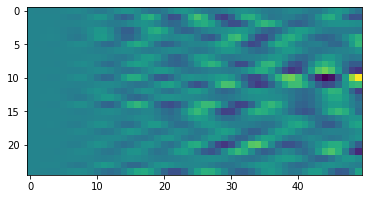

In [36]:
import copy
x =masking(copy.deepcopy(x1), number_of_subjects, 'freq-b', channels)
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(x[0][0,:,:50])
plt.show()

###coatnets

In [ ]:
from math import ceil
import torch
from torch import nn
from torch.nn.utils import weight_norm
import torch.nn.functional as F
import math

##############  EEG_CoatNet models #############################################################

class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        # Do your print / debug stuff here
        print(x.shape)
        return x

class Ensure4d(nn.Module):
    def forward(self, x):
        while(len(x.shape) < 4):
            x = x.unsqueeze(-1)
        return x


class Expression(nn.Module):
    """Compute given expression on forward pass.
    Parameters
    ----------
    expression_fn : callable
        Should accept variable number of objects of type
        `torch.autograd.Variable` to compute its output.
    """

    def __init__(self, expression_fn):
        super(Expression, self).__init__()
        self.expression_fn = expression_fn

    def forward(self, *x):
        return self.expression_fn(*x)

    def __repr__(self):
        if hasattr(self.expression_fn, "func") and hasattr(
            self.expression_fn, "kwargs"
        ):
            expression_str = "{:s} {:s}".format(
                self.expression_fn.func.__name__, str(self.expression_fn.kwargs)
            )
        elif hasattr(self.expression_fn, "__name__"):
            expression_str = self.expression_fn.__name__
        else:
            expression_str = repr(self.expression_fn)
        return (
            self.__class__.__name__ +
            "(expression=%s) " % expression_str
        )

############## Multi-head Attention Mechanism #################################################

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)


    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, embed_dim = x.size()
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, self.embed_dim)
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o



############## stem_stage (reducing temporal dimension) #################################################
class stem_stage(nn.Module):
    def __init__(self, in_channels, out_channels, k ):
        super().__init__()
        def _permute(x):
            '''
            Permutes data:
            from dim:
            batch, chans, time, 1
            to dim:
            batch, chans, 1, time'''
            return x.permute([0, 1, 3, 2])

        prnt=PrintLayer()
      
        layers = [Ensure4d(),
                Expression(_permute),
                nn.Conv2d(in_channels, out_channels, kernel_size=(1,k)),
                nn.BatchNorm2d(out_channels),
                nn.GELU()
                ]

        self.model= nn.Sequential(*layers)
      
    def forward(self, x):
      return self.model(x)

############## conv_stage #################################################
class conv_stage(nn.Module):
    def __init__(self, in_channels, out_channels, n_ch, conv_kernel, pool_kernel):
        super().__init__()

        prnt=PrintLayer()
        self.pool=nn.AvgPool2d(kernel_size=(1, pool_kernel))
        self.res=nn.Conv2d(in_channels, out_channels, kernel_size=(1,1), padding='same')
        layers = [nn.BatchNorm2d(in_channels),
                  nn.Conv2d(in_channels, out_channels, kernel_size=(1,1), padding='same'),
                  nn.Conv2d(in_channels=n_ch, out_channels=n_ch, kernel_size=(1,conv_kernel),groups=n_ch, padding='same'),
                nn.Conv2d(out_channels, out_channels, kernel_size=(1,1), padding='same'),
                nn.ReLU()
                ]

        self.model= nn.Sequential(*layers)
      
    def forward(self, x):
      return self.pool(self.res(x))+self.pool(self.model(x))

############## InceptionBlock #################################################
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, n_ch, kernel_list, pool_kernel):        
        super().__init__()

        self.branch1 = conv_stage(in_channels, out_channels, n_ch, conv_kernel=kernel_list[0], pool_kernel=2)
        self.branch2 = conv_stage(in_channels, out_channels, n_ch, conv_kernel=kernel_list[1], pool_kernel=2)
        self.branch3 = conv_stage(in_channels, out_channels, n_ch, conv_kernel=kernel_list[2], pool_kernel=2)
        self.branch4 = conv_stage(in_channels, out_channels, n_ch, conv_kernel=kernel_list[3], pool_kernel=2)

    def forward(self, x):
        branches = (self.branch1, self.branch2, self.branch3, self.branch4)
        return torch.cat([branch(x) for branch in branches], 1)


############## att_stage #################################################

class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x): 
        return self.net(x)
        
class att_stage(nn.Module):
    def __init__(self, embed_dim, num_heads, in_channels, temp_dim, pool_kernel, incep=1, masking_rate=0.1):
        super().__init__()

        prnt=PrintLayer()
        self.mr=masking_rate
        self.incep=incep
        self.ed=embed_dim
        self.ic= in_channels
        self.ln=nn.LayerNorm(temp_dim)
        self.mha=MultiheadAttention(temp_dim ,embed_dim, num_heads)
        self.ffn=FeedForward(temp_dim, temp_dim, embed_dim)
      
    def forward(self, x):
      x=torch.squeeze(x)
      #x1=self.pool(x)
      x1=self.ffn(x)
      x=self.ln(x)
      #x=self.pool(x)
      mask=(torch.cuda.FloatTensor(self.ic*self.incep, self.ic*self.incep).uniform_() > self.mr).type(torch.uint8)
      x,s=self.mha(x, mask, return_attention=True)
      return x+x1.reshape([-1,self.ic*self.incep,self.ed]),  s
      






#residual block
class residual_block(nn.Module):
    def __init__(self, in_channels, out_channels, k, p,stride=1):
        """
        Args:
          in_channels (int):  Number of input channels.
          out_channels (int): Number of output channels.
          stride (int):       Controls the stride.
        """
        super(residual_block, self).__init__()

        self.skip = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
          self.skip = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, padding='same', bias=False),
            nn.AvgPool2d(kernel_size=(1,p)),
            nn.BatchNorm2d(out_channels))
        else:
          self.skip = None

        self.block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(1,k), padding='same', bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=(1,p)),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=(1,k), padding='same', bias=False),
            nn.BatchNorm2d(out_channels))

    def forward(self, x):
      out = self.block(x)
      out += (x if self.skip is None else self.skip(x))
      out = F.relu(out)
      return out


############## CoatNet #################################################
class coatnet(nn.Module):
    def __init__(self, n_classes, n_channels, embed_dim, num_heads, conv_kernel, pool_kernel, incep=4):
        super().__init__()

        n_ch=n_channels
        self.s0=stem_stage(n_ch, n_ch, pool_kernel)
        self.s11= InceptionBlock(n_ch, n_ch, n_ch, [8, 12 ,16 ,24], pool_kernel)
        temp_dim=281
        self.s2=att_stage(128, num_heads, 14, temp_dim, pool_kernel, incep)
        self.res1=residual_block(4, 1, 3, 1,stride=2)

        self.classifier=nn.Linear(n_ch*embed_dim*incep, n_classes)
        self.classifier=nn.Linear(3934, n_classes)

        #================================


      
    def forward(self, x):
      x=x.reshape([-1,1,25,1125])
      x=self.s11(x)
      #print(x.shape)
      x=torch.flatten(x, 1)
      x=self.classifier(x)
      return x

In [ ]:
eeg = torch.randn(60,25,1125).to(device)
network=coatnet(n_classes=4, n_channels=25, embed_dim=64, num_heads=8, conv_kernel=10, pool_kernel=2, incep=1).to(device)
print(sum(p.numel() for p in network.parameters() if p.requires_grad))
out=network(eeg)

### Yassine's cnn

In [15]:
class ConvNet(torch.nn.Module):
    def __init__(self, n_chan, fm, n_convs, init_pool, kernel_size):
        super(ConvNet, self).__init__()
        self.pool = torch.nn.AvgPool1d(init_pool)
        self.conv = torch.nn.Conv1d(n_chan, fm, kernel_size = kernel_size, padding = kernel_size // 2, bias = False)
        self.bn = torch.nn.BatchNorm1d(fm)
        self.blocks = []
        newfm = fm
        oldfm = fm
        for i in range(n_convs):
            if i > 0:
                newfm = int(1.414 * newfm)
            self.blocks.append(torch.nn.Sequential(
                (torch.nn.Conv1d(oldfm, newfm, kernel_size = kernel_size, padding = kernel_size // 2, bias = False)),
                (torch.nn.BatchNorm1d(newfm)),
                (torch.nn.MaxPool1d(2) if i > 0 - 1 else torch.nn.MaxPool1d(1)),
                (torch.nn.ReLU()),
                (torch.nn.Conv1d(newfm, newfm, kernel_size = kernel_size, padding = kernel_size // 2, bias = False)),
                (torch.nn.BatchNorm1d(newfm)),
                (torch.nn.ReLU())
            ))
            oldfm = newfm
        self.blocks = torch.nn.ModuleList(self.blocks)
        self.fc = torch.nn.Linear(oldfm, 4)
    

    def forward(self, x):
        y = torch.relu(self.bn(self.conv(self.pool(x))))
        for seq in self.blocks:
            y = seq(y)
        y = y.mean(dim = 2)
        return self.fc(y)
    

In [16]:
eeg = torch.randn(60,25,1125).to(device)
params = [64, 4, 4, 7]
network=ConvNet(eeg.shape[1], params[0], params[1], params[2], params[3]).to(device)
print(sum(p.numel() for p in network.parameters() if p.requires_grad))
out=network(eeg)

744583


### EEG-ITNET

In [ ]:
# Authors: Ghaith Bouallegue <ghaithbouallegue@gmail.com>
#
# License: BSD-3
import torch
from torch import nn

#from .modules import Ensure4d, Expression


class _DepthwiseConv2d(torch.nn.Conv2d):
    def __init__(
            self,
            in_channels,
            depth_multiplier=2,
            kernel_size=3,
            stride=1,
            padding=0,
            dilation=1,
            bias=True,
            padding_mode="zeros",
    ):
        out_channels = in_channels * depth_multiplier
        super().__init__(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=in_channels,
            bias=bias,
            padding_mode=padding_mode,
        )


class _InceptionBlock(nn.Module):
    def __init__(self, branches):
        super().__init__()
        self.branches = nn.ModuleList(branches)

    def forward(self, x):
        return torch.cat([branch(x) for branch in self.branches], 1)


class _TCBlock(nn.Module):
    def __init__(self, in_ch, kernel_sz, dialation, padding, drop_prob=0.4):
        super().__init__()
        self.pad = padding
        self.tc1 = nn.Sequential(_DepthwiseConv2d(
                    in_ch,
                    kernel_size=(1, kernel_sz),
                    depth_multiplier=1,
                    dilation=(1, dialation),
                    bias=False,
                    padding="valid",
                ),
                nn.BatchNorm2d(in_ch),
                nn.ELU(),
                nn.Dropout(drop_prob))

        self.tc2 = nn.Sequential(_DepthwiseConv2d(
                    in_ch,
                    kernel_size=(1, kernel_sz),
                    depth_multiplier=1,
                    dilation=(1, dialation),
                    bias=False,
                    padding="valid",
                ),
                nn.BatchNorm2d(in_ch),
                nn.ELU(),
                nn.Dropout(drop_prob))

    def forward(self, x):
        residual = x
        paddings = (self.pad, 0, 0, 0, 0, 0, 0, 0)
        x = nn.functional.pad(x, paddings)
        x = self.tc1(x)
        x = nn.functional.pad(x, paddings)
        x = self.tc2(x) + residual
        return x


class EEG_ITNET(nn.Sequential):
    """ EEG-ITNet: An Explainable Inception Temporal
     Convolutional Network for motor imagery classification from
     Salami et. al 2022.

    See [Salami2022]_ for details.

    Code adapted from https://github.com/abbassalami/eeg-itnet

    Parameters
    ----------
    n_classes: int
        number of outputs of the decoding task (for example number of classes in
        classification)
    n_in_chans: int
        number of input EEG channels
    input_window_samples : int
        Number of time samples.
    drop_prob: float
        Dropout probability.

    References
    ----------
    .. [Salami2022] A. Salami, J. Andreu-Perez and H. Gillmeister, "EEG-ITNet: An Explainable
    Inception Temporal Convolutional Network for motor imagery classification," in IEEE Access,
    doi: 10.1109/ACCESS.2022.3161489.

    Notes
    -----
    This implementation is not guaranteed to be correct, has not been checked
    by original authors, only reimplemented from the paper based on author implementation.
    """

    def __init__(self, n_classes, in_channels, input_window_samples,
                 drop_prob=0.4):
        super().__init__()

        def _permute(x):
            """
            Permutes data:

            from dim:
            batch, chans, time, 1

            to dim:
            batch, 1, chans, time

            """
            return x.permute([0, 3, 1, 2])
        # ======== handling EEG input ========================
        self.add_module("input_preprocess", nn.Sequential(
            Ensure4d(),
            Expression(_permute)))
        # ======== Inception branches ========================
        block11 = self._get_inception_branch(
            in_channels=in_channels, out_channels=2, kernel_length=16
        )
        block12 = self._get_inception_branch(
            in_channels=in_channels, out_channels=4, kernel_length=32
        )
        block13 = self._get_inception_branch(
            in_channels=in_channels, out_channels=8, kernel_length=64
        )
        self.add_module("inception_block", _InceptionBlock((block11, block12, block13)))
        self.pool1 = self.add_module("pooling", nn.Sequential(
         nn.AvgPool2d(kernel_size=(1, 4)),
         nn.Dropout(drop_prob)))
        # =========== TC blocks =====================
        self.add_module("TC_block1", _TCBlock(in_ch=14, kernel_sz=4, dialation=1, padding=3))
        # ================================
        self.add_module("TC_block2", _TCBlock(in_ch=14, kernel_sz=4, dialation=2, padding=6))
        # ================================
        self.add_module("TC_block3", _TCBlock(in_ch=14, kernel_sz=4, dialation=4, padding=12))
        # ================================
        self.add_module("TC_block4", _TCBlock(in_ch=14, kernel_sz=4, dialation=8, padding=24))

        # ============= dimensionality reduction ===================
        self.add_module("dim_reduction", nn.Sequential(
                nn.Conv2d(14, 28, kernel_size=(1, 1)),
                nn.BatchNorm2d(28),
                nn.ELU(),
                nn.AvgPool2d((1, 4)),
                nn.Dropout(drop_prob)))
        # ============== Classifier ==================
        self.add_module("classifier", nn.Sequential(torch.nn.Flatten(),
                        nn.Linear(int(int(input_window_samples / 4) / 4) * 28, n_classes),
                        nn.Softmax(dim=1)))
        # ================================

    @staticmethod
    def _get_inception_branch(in_channels, out_channels, kernel_length, depth_multiplier=1):
        return nn.Sequential(
            nn.Conv2d(
                1, out_channels, kernel_size=(1, kernel_length), padding="same", bias=False
            ),
            nn.BatchNorm2d(out_channels),
            _DepthwiseConv2d(
                out_channels,
                kernel_size=(in_channels, 1),
                depth_multiplier=depth_multiplier,
                bias=False,
                padding="valid",
            ),
            nn.BatchNorm2d(out_channels),
            nn.ELU())


In [ ]:
device='cuda'

from braindecode.models import EEGNetv4,TIDNet,TCN
eeg = torch.randn(60,22,100).to(device)
network=   .to(device)
print(sum(p.numel() for p in network.parameters() if p.requires_grad))
out=network(eeg)
print(out.shape)

SyntaxError: ignored

###Models

In [ ]:
from math import ceil
import torch
from torch import nn
from torch.nn.utils import weight_norm
import torch.nn.functional as F
import math
##############  Attention mechanism (still on testing phase) #############################################################

def attention(q, k, v, d_k, mask=None, dropout=None):
    
    scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)
    if mask is not None:
            mask = mask.unsqueeze(1)
            scores = scores.masked_fill(mask == 0, -1e9)
    scores = F.softmax(scores, dim=-1)
        
    if dropout is not None:
        scores = dropout(scores)
        
    output = torch.matmul(scores, v)
    return output
###############################################################
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout = 0.1):
        super().__init__()
        
        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads
        
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)
    
    def forward(self, q, k, v, mask=None):
        
        bs = q.size(0)
        
        # perform linear operation and split into h heads
        
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)
        
        # transpose to get dimensions bs * h * sl * d_model
       
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)
        # calculate attention using function we will define next
        scores = attention(q, k, v, self.d_k, mask, self.dropout)
        
        # concatenate heads and put through final linear layer
        concat = scores.transpose(1,2).contiguous()\
        .view(bs, -1, self.d_model)
        
        output = self.out(concat)
    
        return output


##############  TIDNet modules #############################################################

class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        # Do your print / debug stuff here
        print(x.shape)
        return x

class Ensure4d(nn.Module):
    def forward(self, x):
        while(len(x.shape) < 4):
            x = x.unsqueeze(-1)
        return x


class Expression(nn.Module):
    """Compute given expression on forward pass.
    Parameters
    ----------
    expression_fn : callable
        Should accept variable number of objects of type
        `torch.autograd.Variable` to compute its output.
    """

    def __init__(self, expression_fn):
        super(Expression, self).__init__()
        self.expression_fn = expression_fn

    def forward(self, *x):
        return self.expression_fn(*x)

    def __repr__(self):
        if hasattr(self.expression_fn, "func") and hasattr(
            self.expression_fn, "kwargs"
        ):
            expression_str = "{:s} {:s}".format(
                self.expression_fn.func.__name__, str(self.expression_fn.kwargs)
            )
        elif hasattr(self.expression_fn, "__name__"):
            expression_str = self.expression_fn.__name__
        else:
            expression_str = repr(self.expression_fn)
        return (
            self.__class__.__name__ +
            "(expression=%s) " % expression_str
        )


class _TemporalFilter(nn.Module):
    def __init__(self, in_chans, filters, depth, temp_len, drop_prob=0., activation=nn.LeakyReLU,
                 residual='netwise'):
        super().__init__()
        temp_len = temp_len + 1 - temp_len % 2
        self.residual_style = str(residual)
        net = list()

        for i in range(depth):
            dil = depth - i
            conv = weight_norm(nn.Conv2d(in_chans if i == 0 else filters, filters,
                                         kernel_size=(1, temp_len), dilation=dil,
                                         padding=(0, dil * (temp_len - 1) // 2)))
            net.append(nn.Sequential(
                conv,
                activation(),
                nn.Dropout2d(drop_prob)
            ))
        if self.residual_style.lower() == 'netwise':
            self.net = nn.Sequential(*net)
            self.residual = nn.Conv2d(in_chans, filters, (1, 1))
        elif residual.lower() == 'dense':
            self.net = net

    def forward(self, x):
        if self.residual_style.lower() == 'netwise':
            return self.net(x) + self.residual(x)
        elif self.residual_style.lower() == 'dense':
            for layer in self.net:
                x = torch.cat((x, layer(x)), dim=1)
            return x


############## MLP blocks #################################################
class MLP_blocks(nn.Module):
    def __init__(self, arch, in_channels):
        super().__init__()
        layers = []
        prnt=PrintLayer()
        for x in arch:
            layers += [nn.Linear(in_channels, x),
                        nn.BatchNorm1d(x),
                        nn.ReLU()]
            in_channels = x

        self.model= nn.Sequential(*layers)
      
    def forward(self, x):
      return self.model(x)

############## spatial convs(electrodes,1) (electrode aggregator)  (still on testing phase) #################################################
class spatial_aggregator(nn.Module):
    def __init__(self, out, in_channels, k ):
        super().__init__()
        layers = []
            
        layers += [nn.Conv2d(in_channels, out, (k,1)),
                    nn.BatchNorm2d(out),
                    nn.ReLU(),
                    nn.AvgPool2d(kernel_size=(7,1), stride=(1,2))]

        self.model= nn.Sequential(*layers)
      
    def forward(self, x):
      return self.model(x)

############## electrode weight-sharing convs(1,1) (a.k.a 1x1encoders) #################################################
class SharedSpaceTimeConv1x1(nn.Module):
    def __init__(self, mode, arch, in_channels):
        super().__init__()
        def _permute(x):
            """
            Permutes data:
            from dim:
            batch, chans, time, 1
            to dim:
            batch, 1, chans, time
            """
            return x.permute([0, 3, 1, 2])
        prnt=PrintLayer()
        if mode=='1x1':
            layers = [Ensure4d(),
                Expression(_permute),]
            in_channels = 1
        else:
            layers = []
        for x in arch:
            s=str(x)
            if s[0] == 'A':
                layers += [nn.AvgPool2d(kernel_size=(1, int(s[1:])), stride=(1,2))]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU()]
                in_channels = x

        self.model= nn.Sequential(*layers)
      
    def forward(self, x):
      return self.model(x)


############## TIDNet temporal block #################################################
class TemporalTIDNet(nn.Module):
    def __init__(self, t_filters, input_window_samples, drop_prob, pooling,
                 temp_layers,  temp_span):
        super().__init__()
        self.temp_len = ceil(temp_span * input_window_samples)

        def _permute(x):
            """
            Permutes data:
            from dim:
            batch, chans, time, 1
            to dim:
            batch, 1, chans, time
            """
            return x.permute([0, 3, 1, 2])

        self.temporal = nn.Sequential(
            Ensure4d(),
            Expression(_permute),
            _TemporalFilter(1, t_filters, depth=temp_layers, temp_len=self.temp_len),
            nn.MaxPool2d((1, pooling)),
            nn.Dropout2d(drop_prob),
        )

    def forward(self, x):
        x = self.temporal(x)
        return x


###################################################################################### 

class TemporalShareSpaceTime(nn.Module):

    def __init__(self, mode, arch, n_classes, in_chans, input_window_samples, t_filters,
                 drop_prob, pooling, temp_layers, temp_span):
        super().__init__()
        def compute_params(arch,h,w):
            ### height and width of the input convolutions of each feature map
            #### compute the number of inputs after flatten ######
            for i in arch:
                s=str(i)
                if s[0] == 'A':
                    w=int((w-int(s[1:]))/2 +1 )     #for average pooling we apply:  [(Output width + padding width right + padding width left - kernel width) / (stride width)] + 1
            s=str(i)
            if s[0] == 'A':
                last_filter=arch[-2]
            else:
                last_filter=arch[-1]
            return int(last_filter*h*w)

        self.mode=mode
        self.n_classes = n_classes
        self.in_chans = in_chans
        self.input_window_samples = input_window_samples
        self.temp_len = ceil(temp_span * input_window_samples)
        self.params=compute_params(arch,in_chans,ceil((input_window_samples/pooling)-1))   
        
        ######################################################
        
        if self.mode!='1x1':
            self.tidnet_temp = TemporalTIDNet(t_filters=t_filters,
                                     input_window_samples=input_window_samples,
                                     drop_prob=drop_prob, pooling=pooling, temp_layers=temp_layers,
                                     temp_span=temp_span)     

        if self.mode=='1x1' or self.mode=='t+1x1':
            self.model = SharedSpaceTimeConv1x1(self.mode, arch, t_filters) 
            if self.mode=='1x1':
                self.params=compute_params(arch,in_chans,input_window_samples)
            self.fc_block = nn.Linear(self.params, self.n_classes)
        elif self.mode=='mlp':
            self.model = MLP_blocks(arch, in_chans*ceil((input_window_samples/pooling))*t_filters)
            self.fc_block = nn.Linear(arch[-1], self.n_classes)

    

    def forward(self, x):
        """Forward pass.
        Parameters
        ----------
        x: torch.Tensor
            Batch of EEG windows of shape (batch_size, n_channels, n_times).
        """
        if self.mode!='1x1':
            x = self.tidnet_temp(x)
        
        if self.mode!='mlp':
            x = self.model(x)
            x = torch.flatten(x, 1)
            out = self.fc_block(x)

        else :
            x = torch.flatten(x, 1)
            x = self.model(x)
            out = self.fc_block(x)
        return out
    
    def get_emb(self, x):
        return self.tidnet_temp(x)

############################################################################


###Train

In [17]:
import wandb
import os
import torch 
from torch import optim
from sklearn.metrics import f1_score
import torch.nn.functional as F
from torch.autograd import Variable
from torchinfo import summary
import gc



from braindecode.models import EEGNetv4,TIDNet
def build_network(model, params, n_classes=4, in_chans=25, input_window_samples=1125, t_filters=32,
                 drop_prob=0.4, pooling=15, temp_layers=2, temp_span=0.05):
    if model=='tidnet':
      model=EEGNetv4(in_chans,n_classes,input_window_samples)
    elif model=='tidnet':
      model=TIDNet(in_chans,n_classes,input_window_samples)
    elif model=='eeg-itnet':
      model=TCN(22, 4, 4, 32, 2, 0.2, True)
    elif model=='yassinet':
      model=ConvNet(in_chans, params[0], params[1], params[2], params[3])
  
    return model


def build_optimizer(network, optimizer, learning_rate):
    if optimizer == "sgd":
        optimizer = optim.SGD(network.parameters(),
                              lr=learning_rate, momentum=0.9, weight_decay=0.5*0.001)
    elif optimizer == "adamw":
        optimizer = optim.AdamW(network.parameters(),
                               lr=learning_rate,  weight_decay=0.01, amsgrad=True)
    return optimizer



####### Training using mixup #####################################################################
def mixup_data(x, y, alpha=5.0, beta=5.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, beta)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


def train_mixup(network, optimizer, train_loader):
    cumu_loss = 0
    correct = 0.0
    total = 0.0
    criterion = torch.nn.CrossEntropyLoss()   
    
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):    

        # Clear the gradients
        optimizer.zero_grad()

        # Forward pass :
        ## implement mixup with alpha preset to 2
        inputs, targets_a, targets_b, lam = mixup_data(data, target, use_cuda=True)
        inputs, targets_a, targets_b = map(Variable, (inputs,
                                                    targets_a, targets_b))


        outputs = network(inputs)

        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        
        cumu_loss += loss.item()
    
        # ⬅ Backward pass + weight update
        loss.backward()
        optimizer.step()

        # compute accuracy
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += target.size(0)
        correct += (lam * predicted.eq(targets_a.data).cpu().sum().float()
                    + (1 - lam) * predicted.eq(targets_b.data).cpu().sum().float())



    return cumu_loss / batch_idx*data.shape[0], correct/total
############################################################################

def train_epoch(network, optimizer, train_loader):
    cumu_loss = 0
    correct = 0.0
    total = 0.0
    
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):        

        r=random.uniform(0, 1)
        #if r<0.52:
          #data=apply_da(data,selection)
        # Clear the gradients
        optimizer.zero_grad()

        # Forward pass 

        outputs = network(data)
        loss = F.cross_entropy(outputs, target)
        cumu_loss += loss.item()
    
        # ⬅ Backward pass + weight update
        loss.backward()
        optimizer.step()
    
        # compute accuracy
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += target.size(0)
        correct += (predicted == target).sum()


    return cumu_loss / batch_idx*data.shape[0], correct/total


def validate_epoch(network, valid_loader):
    cumu_loss = 0
    correct = 0.0
    total = 0.0
    
    network.eval()
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(valid_loader):  

            loss = F.cross_entropy(network(data), target)
            cumu_loss += loss.item()     

            # compute accuracy
            outputs = network(data)

            # Get predictions from the maximum value
            _, predicted = torch.max(outputs.data, 1)

            # Total number of labels
            total += target.size(0)
            correct += (predicted == target).sum()   

    
    return cumu_loss / batch_idx*data.shape[0], correct/total


def test(network, test_loader , classes, batchnorm):
    n_classes=classes
    # Calculate Accuracy
    correct = 0.0
    correct_arr = [0.0] * n_classes
    total = 0.0
    total_arr = [0.0] * n_classes
    y_true=[]
    y_pred=[]
    pred_probs=[]
    # Iterate through test dataset
    if batchnorm:
      network.train()
    else:
      network.eval()   
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):  

            outputs = network(data)
            
            # Get predictions from the maximum value
            _, predicted = torch.max(outputs.data, 1)
            # Total number of labels
            total += target.size(0)
            correct += (predicted == target).sum()
            y_true.append(target.cpu().detach().numpy())
            y_pred.append(predicted.cpu().detach().numpy())
            pred_probs.append(outputs.data.cpu().detach().numpy())
            
            for label in range(n_classes):
                correct_arr[label] += (((predicted == target) & (target==label)).sum())
                total_arr[label] += (target == label).sum()
    
    y_true=np.array(y_true[:-1]).reshape([-1])
    y_pred=np.array(y_pred[:-1]).reshape([-1])
    pred_probs=np.array(pred_probs[:-1]).reshape([-1,n_classes])


    '''# Confusion Matrices
    wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None,
                        y_true=y_true , preds=y_pred ,
                        class_names=classes)})


    # ROC
    wandb.log({"roc" : wandb.plot.roc_curve(  y_true , pred_probs ,
                            labels=classes)})


    # Precision Recall Curve
    wandb.log({"pr" : wandb.plot.pr_curve( y_true , pred_probs ,
                        labels=classes, classes_to_plot=None)})'''

    
    f1=f1_score( y_true, y_pred, average='macro')
    #wandb.log({'Test macro F1-Score': f1})
    print(f1)
    accuracy = correct / total
    print('TEST ACCURACY {} '.format(accuracy))
                          
    return accuracy, f1



def train_sweep(x, y, number_of_subjects, device, bad_subjects, config, dataset, run, resultdir, kfold):
    
    gc.collect()
    torch.cuda.empty_cache()

    #run_name = run.name
    batch_size= 64 #config.batch_size
    patience =20# config.patience
    LR= 1e-3 #config.learning_rate
    optim= 'adamw' #config.optimizer
    
    # config.subject
    if dataset=='bci4':
      T_x,T_y,V_x,V_y,Test_x,Test_y=loso(x, y, number_of_subjects, kfold, device, bad_subjects, with_validation=False)
    else:
      T_x,T_y,V_x,V_y,Test_x,Test_y=lmso(x, y, number_of_subjects, kfold, device, bad_subjects, with_validation=False)
    train_loader, valid_loader, test_loader=loaders(kfold, T_x, T_y, V_x, V_y, Test_x, Test_y, batch_size)


    if dataset=='bci4':
      params = [64, 4, 4, 7] #best params for BCI4
    elif dataset=='physionet MI':
      params = [48, 5, 4, 7] #best params for Physionet MI
    elif dataset=='Cho 2017':
      params = [48, 4, 4, 7] #best params for Cho17

    model='yassinet'
    network = build_network(model, params, n_classes=T_y.unique().shape[0], in_chans=T_x.shape[1], input_window_samples=T_x.shape[2]).to(device)    ###config.model
    pytorch_total_params = sum(p.numel() for p in network.parameters() if p.requires_grad)
    #wandb.log({"total number of parameters": pytorch_total_params})
    optimizer=build_optimizer(network, optim, LR)
    #if config.mixup:
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer = optimizer, step_size = 40, gamma = 0.1)


    Train_acc=[]
    Val_acc=[]
    Train_loss=[]
    Val_loss=[]
    Test_acc=[]
    ## Tensorboard iterators
    tr_iter=0
    v_itr=0
    maxv=0
    cpt_early = 0

    for epoch in range(120):
        #if config.mixup:
        train_loss,train_acc = train_mixup(network, optimizer, train_loader)
        #else:
        #  train_loss,train_acc = train_epoch(network, optimizer, train_loader)
        print('train loss {} accuracy {} epoch {} done'.format(train_loss,train_acc,epoch))
        #if config.mixup:
        scheduler.step()
      
        #wandb.log({'Training accuracy': train_acc,'Training loss': train_loss});   ## use this when no validation set is used

        '''val_loss,val_acc = validate_epoch(network, valid_loader)
        #print('val loss {} epoch {} done'.format(val_loss,epoch))

        Train_acc.append(train_acc)
        Val_acc.append(val_acc)
        Train_loss.append(train_loss)
        #Val_loss.append(val_loss)
        #wandb.log({'Training accuracy': train_acc,'Training loss': train_loss,'Validation accuracy': val_acc,'Validation loss': val_loss});

        
        if maxv<val_acc:
            print(f"Epoch {epoch}, new best val accuracy {val_acc} and loss {val_loss}")
            maxv=val_acc

            ckpt_dict = {
            'weights': network.state_dict(),
            'train_acc': Train_acc,
            'val_acc': Val_acc,
            'train_loss': Train_loss,
            'val_acc': Val_loss,
            'epoch': epoch
            }
            torch.save(ckpt_dict,os.path.join(resultdir,f"{run_name}_bestval.pth") )
            cpt_early = 0
        else:
            cpt_early +=1
        
        if cpt_early == patience:
            print("Early Stopping")
            wandb.log({'Maximum validation accuracy': maxv})
            break
    
    print("Reloading best validation model")
    ckpt_dict = torch.load(os.path.join(resultdir,f"{run_name}_bestval.pth") )

    print(f"Reloading best model at epoch {ckpt_dict['epoch']}")
    network.load_state_dict(ckpt_dict['weights'])'''
    print("Saving the model")
    ckpt_dict = {
            'weights': network.state_dict(),
            'train_acc': Train_acc,
            'val_acc': Val_acc,
            'train_loss': Train_loss,
            'val_acc': Val_loss,
            'epoch': epoch
            }
    torch.save(ckpt_dict,os.path.join(resultdir+'subject'+str(kfold)+'.pth') )

    #test_acc,f1=test(network, test_loader , T_y.unique().shape[0], True)
    #wandb.log({'Test accuracy': test_acc})

    return network

###Main

In [43]:
def test_mask(model,x, y, number_of_subjects, device, bad_subjects, config, dataset, resultdir):
    torch.cuda.empty_cache()
    kfold= config.subject
    
    print("Reloading the model")
    ckpt_dict = torch.load(os.path.join(resultdir+'subject'+str(kfold)+'.pth'))

    if dataset=='bci4':
      T_x,T_y,V_x,V_y,Test_x,Test_y=loso(x, y, number_of_subjects, kfold, device, bad_subjects, with_validation=False)
    else:
      T_x,T_y,V_x,V_y,Test_x,Test_y=lmso(x, y, number_of_subjects, kfold, device, bad_subjects, with_validation=False)
    train_loader, valid_loader, test_loader=loaders(kfold, T_x, T_y, V_x, V_y, Test_x, Test_y, config.batch_size)

    test_acc,f1=test(model, test_loader , T_y.unique().shape[0], True)
    #wandb.log({'Masking test accuracy': test_acc})

    return test_acc

In [44]:
bbbb=list(np.around(np.arange(0,2.6,0.1), decimals=1))
print(bbbb)

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5]


In [45]:
resultdir='/content/resultdir/'
dataset = MOABBDataset(dataset_name="PhysionetMI", subject_ids=[2])
channels=dataset.datasets[0].raw.ch_names
'''channels=channels[:-1]
channels[-3]='Fp1'
channels[-2]='Fpz'
channels[-1]='Fp2' '''

print(channels)
Dataset='physionet MI'

if Dataset=='bci4':
    number_of_subjects=9
    bad_subjects=[] #bad subject for BCI-VI-2a
    x = x1[:]
    y = y1[:]
elif Dataset=='physionet MI':
    number_of_subjects=109
    bad_subjects=[88,90,92,100] #bad subject for Physionet MI
    x = x2[:]
    y = y2[:]
elif Dataset=='Cho 2017':
    number_of_subjects=52
    bad_subjects=[32,46,49] #bad subject for Cho2017
    x = x3[:]
    y = y3[:]

for kfold in range(1,11):
  model=train_sweep(x, y, number_of_subjects, device, bad_subjects, [], Dataset, [] , resultdir, kfold)

  ################################################################################################################################# 
  project_name='EEG_mask_sspectral' #PhysioNet_tests   #bci4_tests   #cho17_tests   #sandbox       EEG_mask_temp

  sweep_config = {
      'method': 'grid', #grid
      'metric': {
        'name': 'loss',
        'goal': 'minimize'   
      },
      'parameters': {
          'dataset': {
              'values': [Dataset]
          },
          'model': {
              'values': ['yassinet']
          },
          'epochs': {
              'values': [120] 
          },
          'batch_size': {
              'values': [64]
          },
          'patience': {
              'values': [60]
          },
      
          'learning_rate': {
              'values': [1e-3]
          },
          'optimizer': {
              'values': ['adamw']
          },
          'loss': {
              'values': ['CrossEntropyLoss'],
          },
          'subject': {
              'values': [kfold]
          },
          'ea': {
              'values': [True]
          },
          'mixup': {
              'values': [True]
          },
          'mask': {
              'values': ['freq-a','freq-b','freq-d','freq-t','freq-g'] 
          },
          #'wind_strt': {
          #    'values': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 
           #              0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 
           #              1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 
           #              2.3, 2.4, 2.5]
          #},       
      }
  } 

  sweep_id = wandb.sweep(sweep_config, project=project_name)
  import copy
  def train_wandb():
      # Initialize a new wandb run
      run = wandb.init(project=project_name, entity="brain-imt" , config=sweep_config)
      assert run is wandb.run
      with run:
          config =wandb.config
          
          x_p =masking(copy.deepcopy(x), number_of_subjects, config.mask, channels)
          test_acc = test_mask(model, x_p, y, number_of_subjects, device, bad_subjects, config, config.dataset, resultdir='/content/resultdir/')
          wandb.log({'Masking test accuracy': test_acc})
      ############################################################################

  #Test_acc= train_wandb()
  wandb.agent(sweep_id, train_wandb)


['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FT8', 'T7', 'T8', 'T9', 'T10', 'TP7', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'Iz']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

train loss 75.93116549026867 accuracy 0.3956908881664276 epoch 0 done
train loss 70.13303695335861 accuracy 0.48664194345474243 epoch 1 done
train loss 68.35287326623585 accuracy 0.5057357549667358 epoch 2 done
train loss 67.00682309737874 accuracy 0.5165722370147705 epoch 3 done
train loss 65.6927327922553 accuracy 0.5303534865379333 epoch 4 done
train loss 64.31103803796216 accuracy 0.5406792759895325 epoch 5 done
train loss 63.20464360516918 accuracy 0.5547981262207031 epoch 6 done
train loss 63.20126150560773 accuracy 0.5517901182174683 epoch 7 done
train loss 62.65650259561775 accuracy 0.5566766858100891 epoch 8 done
train loss 62.23726021849419 accuracy 0.5643926858901978 epoch 9 done
train loss 61.093713175166734 accuracy 0.5786980986595154 epoch 10 done
train loss 60.199341694185556 accuracy 0.5868335962295532 epoch 11 done
train loss 60.295626276780744 accuracy 0.5777734518051147 epoch 12 done
train loss 59.32445957049851 accuracy 0.58978271484375 epoch 13 done
train loss 59.3

wandb: Agent Starting Run: 4emnkp9k with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-a
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model
nan
TEST ACCURACY 0.3256579041481018 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.32566


wandb: Agent Starting Run: bcu1l58v with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-b
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.2785087823867798 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.27851


wandb: Agent Starting Run: 2zkwgvmw with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-d
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.46271929144859314 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.46272


wandb: Agent Starting Run: iyc1ye6p with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-t
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.3475877344608307 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.34759


wandb: Agent Starting Run: aqfppc78 with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-g
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.2697368562221527 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.26974


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/loc

train loss 74.77273124308626 accuracy 0.3864828646183014 epoch 0 done
train loss 69.1512783987463 accuracy 0.4751875400543213 epoch 1 done
train loss 67.58610872936643 accuracy 0.4938097894191742 epoch 2 done
train loss 65.96280748341695 accuracy 0.5093517303466797 epoch 3 done
train loss 64.39818020103392 accuracy 0.534689724445343 epoch 4 done
train loss 64.25124366913946 accuracy 0.5285197496414185 epoch 5 done
train loss 62.62692273451277 accuracy 0.5548055768013 epoch 6 done
train loss 62.426056924930286 accuracy 0.5550729632377625 epoch 7 done
train loss 60.971369720687555 accuracy 0.5673764944076538 epoch 8 done
train loss 60.7715952554025 accuracy 0.5711775422096252 epoch 9 done
train loss 59.28775931980985 accuracy 0.5808321833610535 epoch 10 done
train loss 59.10843978243426 accuracy 0.585575520992279 epoch 11 done
train loss 58.93041428603417 accuracy 0.5820478796958923 epoch 12 done
train loss 58.399554185138264 accuracy 0.5873953700065613 epoch 13 done
train loss 57.678754

wandb: Agent Starting Run: bqislrhp with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-a
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 2
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model
nan
TEST ACCURACY 0.29791897535324097 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.29792


wandb: Agent Starting Run: nlmseqf4 with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-b
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 2
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.2869660556316376 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.28697


wandb: Agent Starting Run: 76waitwx with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-d
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 2
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.5323110818862915 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.53231


wandb: Agent Starting Run: n37yv5y0 with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-t
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 2
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.3351588249206543 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.33516


wandb: Agent Starting Run: ts7kvsky with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-g
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 2
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.2617743909358978 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.26177


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/loc

train loss 74.65372333152234 accuracy 0.3903524875640869 epoch 0 done
train loss 69.55992152818963 accuracy 0.4762606620788574 epoch 1 done
train loss 67.8429599286111 accuracy 0.49177053570747375 epoch 2 done
train loss 66.48349478865458 accuracy 0.5116081237792969 epoch 3 done
train loss 64.948856394153 accuracy 0.5283167958259583 epoch 4 done
train loss 64.70078337340315 accuracy 0.5248332619667053 epoch 5 done
train loss 63.953107011712284 accuracy 0.5320761799812317 epoch 6 done
train loss 63.42728119546717 accuracy 0.5421423316001892 epoch 7 done
train loss 62.38440571983984 accuracy 0.5494478940963745 epoch 8 done
train loss 61.182550317492364 accuracy 0.5595793724060059 epoch 9 done
train loss 60.40899296782234 accuracy 0.5711802840232849 epoch 10 done
train loss 61.279365989294924 accuracy 0.5607953667640686 epoch 11 done
train loss 59.50361143064893 accuracy 0.5829840302467346 epoch 12 done
train loss 59.54717804774765 accuracy 0.5757071375846863 epoch 13 done
train loss 58.6

wandb: Agent Starting Run: psidbt5h with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-a
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 3
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model
nan
TEST ACCURACY 0.3187294900417328 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.31873


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: t310xx4m with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-b
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 3
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.2869660556316376 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.28697


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r672pho7 with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-d
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 3
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.525739312171936 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.52574


wandb: Agent Starting Run: e8ebr3lz with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-t
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 3
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.35487404465675354 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.35487


wandb: Agent Starting Run: bt23t9le with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-g
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 3
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.2705366909503937 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.27054


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/loc

train loss 74.63106555485528 accuracy 0.3929405212402344 epoch 0 done
train loss 69.15155982675631 accuracy 0.48452597856521606 epoch 1 done
train loss 66.97899584533754 accuracy 0.5040185451507568 epoch 2 done
train loss 65.70585890890153 accuracy 0.5201046466827393 epoch 3 done
train loss 64.53196478185575 accuracy 0.5332100987434387 epoch 4 done
train loss 64.07528186583322 accuracy 0.5340165495872498 epoch 5 done
train loss 62.66281526492647 accuracy 0.5453572869300842 epoch 6 done
train loss 62.80089339884845 accuracy 0.5426102876663208 epoch 7 done
train loss 61.89129709606328 accuracy 0.5597976446151733 epoch 8 done
train loss 60.92020962947657 accuracy 0.5690410733222961 epoch 9 done
train loss 60.59309422624998 accuracy 0.5655950903892517 epoch 10 done
train loss 59.795664997632834 accuracy 0.5750165581703186 epoch 11 done
train loss 58.93007136671997 accuracy 0.5831709504127502 epoch 12 done
train loss 58.733246799342886 accuracy 0.5839605927467346 epoch 13 done
train loss 58

wandb: Agent Starting Run: v20yrcd2 with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-a
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 4
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model
nan
TEST ACCURACY 0.3296823799610138 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.32968


wandb: Agent Starting Run: 47iv223w with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-b
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 4
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.30996716022491455 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.30997


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 64ckpbrq with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-d
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 4
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.48521360754966736 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.48521


wandb: Agent Starting Run: iehe92ly with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-t
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 4
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.3570646345615387 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.35706


wandb: Agent Starting Run: jbq8gzap with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-g
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 4
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.28258490562438965 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.28258


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/loc

train loss 75.27605621184199 accuracy 0.3725072145462036 epoch 0 done
train loss 70.11882113031119 accuracy 0.46674829721450806 epoch 1 done
train loss 67.21016861289002 accuracy 0.5012752413749695 epoch 2 done
train loss 66.70841720380074 accuracy 0.5049158334732056 epoch 3 done
train loss 64.93898445663373 accuracy 0.5246809124946594 epoch 4 done
train loss 64.48953011016215 accuracy 0.5364909768104553 epoch 5 done
train loss 63.266202983284785 accuracy 0.5463632345199585 epoch 6 done
train loss 62.935271104012635 accuracy 0.5458611249923706 epoch 7 done
train loss 61.36904951215775 accuracy 0.5649456977844238 epoch 8 done
train loss 61.59681557722328 accuracy 0.5590219497680664 epoch 9 done
train loss 60.8534543888628 accuracy 0.5677844285964966 epoch 10 done
train loss 59.95021617461827 accuracy 0.5710304379463196 epoch 11 done
train loss 59.81792931418774 accuracy 0.5795782208442688 epoch 12 done
train loss 58.95020864571422 accuracy 0.5837288498878479 epoch 13 done
train loss 58.

wandb: Agent Starting Run: ou0r7l85 with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-a
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model
nan
TEST ACCURACY 0.30010953545570374 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.30011


wandb: Agent Starting Run: 5spln5u3 with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-b
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.31544360518455505 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.31544


wandb: Agent Starting Run: ebtb41v1 with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-d
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.5136911273002625 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.51369


wandb: Agent Starting Run: 1bwzemcq with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-t
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.3472070097923279 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.34721


wandb: Agent Starting Run: 5873g98k with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-g
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 5
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.2639649510383606 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.26396


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/loc

train loss 15.671053525878161 accuracy 0.39916107058525085 epoch 0 done
train loss 14.492193384868344 accuracy 0.4886859953403473 epoch 1 done
train loss 14.280105061647369 accuracy 0.49576637148857117 epoch 2 done
train loss 13.93121228566984 accuracy 0.5160911679267883 epoch 3 done
train loss 13.758759620713025 accuracy 0.5206713676452637 epoch 4 done
train loss 13.579521830488996 accuracy 0.5314905643463135 epoch 5 done
train loss 13.35885745723073 accuracy 0.5442360043525696 epoch 6 done
train loss 13.104766921299259 accuracy 0.5528939366340637 epoch 7 done
train loss 12.843829125892825 accuracy 0.5664477348327637 epoch 8 done
train loss 12.877516234793314 accuracy 0.5598167777061462 epoch 9 done
train loss 12.872082477662623 accuracy 0.5647228360176086 epoch 10 done
train loss 12.611568270660028 accuracy 0.5796032547950745 epoch 11 done
train loss 12.301093991209822 accuracy 0.5906139612197876 epoch 12 done
train loss 12.344334119703712 accuracy 0.585507333278656 epoch 13 done
tra

wandb: Agent Starting Run: 7u5zvkmp with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-a
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 6
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model
nan
TEST ACCURACY 0.3132530152797699 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.31325


wandb: Agent Starting Run: o4nelz1o with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-b
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 6
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.3301204741001129 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.33012


wandb: Agent Starting Run: 374rz0ut with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-d
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 6
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.4939759075641632 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.49398


wandb: Agent Starting Run: 7z70beea with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-t
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 6
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.29759037494659424 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.29759


wandb: Agent Starting Run: pumeyje1 with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-g
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 6
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.2722891569137573 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.27229


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/loc

train loss 15.828532009589964 accuracy 0.38818585872650146 epoch 0 done
train loss 14.57158086358047 accuracy 0.47822776436805725 epoch 1 done
train loss 14.23800019520085 accuracy 0.49927082657814026 epoch 2 done
train loss 13.906144665508736 accuracy 0.5181917548179626 epoch 3 done
train loss 13.689285726082034 accuracy 0.5218808650970459 epoch 4 done
train loss 13.467203564760162 accuracy 0.5401313304901123 epoch 5 done
train loss 13.24377727508545 accuracy 0.5511252880096436 epoch 6 done
train loss 13.103748548321608 accuracy 0.5586280226707458 epoch 7 done
train loss 13.009298295509524 accuracy 0.5575602054595947 epoch 8 done
train loss 12.787797451019287 accuracy 0.5670555830001831 epoch 9 done
train loss 12.734630474230137 accuracy 0.5740963220596313 epoch 10 done
train loss 12.613944262993044 accuracy 0.5748217701911926 epoch 11 done
train loss 12.478004827731993 accuracy 0.5841825008392334 epoch 12 done
train loss 12.424486922054754 accuracy 0.5815908312797546 epoch 13 done
tr

wandb: Agent Starting Run: bguwrrnh with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-a
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 7
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model
nan
TEST ACCURACY 0.33253014087677 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.33253


wandb: Agent Starting Run: bdgivrw3 with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-b
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 7
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.3048192858695984 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.30482


wandb: Agent Starting Run: jqau7qvt with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-d
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 7
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.5132530331611633 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.51325


wandb: Agent Starting Run: cptj1xo1 with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-t
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 7
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.3481927812099457 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.34819


wandb: Agent Starting Run: x2e05snc with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-g
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 7
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.27108433842658997 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.27108


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/loc

train loss 15.797891605191115 accuracy 0.3922119438648224 epoch 0 done
train loss 14.647058079882365 accuracy 0.4756327271461487 epoch 1 done
train loss 14.190102908669449 accuracy 0.5075944662094116 epoch 2 done
train loss 14.002740900690963 accuracy 0.5106937289237976 epoch 3 done
train loss 13.714494897098076 accuracy 0.5231429934501648 epoch 4 done
train loss 13.412483860806722 accuracy 0.5442504286766052 epoch 5 done
train loss 13.295766580395583 accuracy 0.5441144108772278 epoch 6 done
train loss 13.028991652698052 accuracy 0.5550653338432312 epoch 7 done
train loss 12.955918637717641 accuracy 0.5598158836364746 epoch 8 done
train loss 12.858879095170556 accuracy 0.5651182532310486 epoch 9 done
train loss 12.710480637666656 accuracy 0.5739946961402893 epoch 10 done
train loss 12.56954219864636 accuracy 0.5785537958145142 epoch 11 done
train loss 12.498799882284025 accuracy 0.5791826844215393 epoch 12 done
train loss 12.300909391263636 accuracy 0.59229576587677 epoch 13 done
train

wandb: Agent Starting Run: t3gyh6h0 with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-a
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 8
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model
nan
TEST ACCURACY 0.30240964889526367 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.30241


wandb: Agent Starting Run: 1fukc5gz with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-b
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 8
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.3156626522541046 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.31566


wandb: Agent Starting Run: 9y3vuf4t with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-d
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 8
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.5084337592124939 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.50843


wandb: Agent Starting Run: 3ohy74g4 with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-t
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 8
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.35180723667144775 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.35181


wandb: Agent Starting Run: woolvi0z with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-g
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 8
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.26265060901641846 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.26265


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/loc

train loss 15.684576662575324 accuracy 0.4024481773376465 epoch 0 done
train loss 14.57925669739886 accuracy 0.48181405663490295 epoch 1 done
train loss 14.12722136334675 accuracy 0.5018959641456604 epoch 2 done
train loss 13.845155768278168 accuracy 0.517742931842804 epoch 3 done
train loss 13.53097425437555 accuracy 0.5344436764717102 epoch 4 done
train loss 13.30449891671902 accuracy 0.5432295799255371 epoch 5 done
train loss 13.173505474881429 accuracy 0.5567318797111511 epoch 6 done
train loss 13.072322496553745 accuracy 0.5564045310020447 epoch 7 done
train loss 12.81862153076544 accuracy 0.5684205293655396 epoch 8 done
train loss 12.792932946507523 accuracy 0.5706980228424072 epoch 9 done
train loss 12.621626510852721 accuracy 0.5726719498634338 epoch 10 done
train loss 12.515910392854272 accuracy 0.581087052822113 epoch 11 done
train loss 12.346719125422037 accuracy 0.5884326696395874 epoch 12 done
train loss 12.464488663324495 accuracy 0.5808010697364807 epoch 13 done
train lo

wandb: Agent Starting Run: h6ilrvp4 with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-a
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 9
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model
nan
TEST ACCURACY 0.30361446738243103 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.30361


wandb: Agent Starting Run: h50ppsio with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-b
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 9
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.31807228922843933 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.31807


wandb: Agent Starting Run: 653h70kx with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-d
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 9
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.4963855445384979 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.49639


wandb: Agent Starting Run: b2liky7l with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-t
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 9
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.32891565561294556 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.32892


wandb: Agent Starting Run: bup74kgi with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-g
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 9
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.2590361535549164 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.25904


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/loc

train loss 15.846363718916729 accuracy 0.3865252733230591 epoch 0 done
train loss 14.713035653277142 accuracy 0.4815129339694977 epoch 1 done
train loss 14.2976308101561 accuracy 0.4970138370990753 epoch 2 done
train loss 14.110285822938128 accuracy 0.5072763562202454 epoch 3 done
train loss 13.771565262864277 accuracy 0.5252057313919067 epoch 4 done
train loss 13.50572081891502 accuracy 0.5355044007301331 epoch 5 done
train loss 13.348436070651545 accuracy 0.5464206337928772 epoch 6 done
train loss 13.193948199109334 accuracy 0.5491787791252136 epoch 7 done
train loss 13.054721966022399 accuracy 0.5580345392227173 epoch 8 done
train loss 12.817943375285079 accuracy 0.5657997131347656 epoch 9 done
train loss 12.9167260309545 accuracy 0.5594197511672974 epoch 10 done
train loss 12.575132288583895 accuracy 0.5755972266197205 epoch 11 done
train loss 12.522561625736515 accuracy 0.5784688591957092 epoch 12 done
train loss 12.42507009389924 accuracy 0.5846959948539734 epoch 13 done
train lo

wandb: Agent Starting Run: 39d0tpop with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-a
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model
nan
TEST ACCURACY 0.32289156317710876 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.32289


wandb: Agent Starting Run: q4o7wl1e with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-b
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.2963855564594269 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.29639


wandb: Agent Starting Run: 4coydq9j with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-d
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.5566264986991882 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.55663


wandb: Agent Starting Run: oqjvs7yf with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-t
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.3879518210887909 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.38795


wandb: Agent Starting Run: 6o4018br with config:
wandb: 	batch_size: 64
wandb: 	dataset: physionet MI
wandb: 	ea: True
wandb: 	epochs: 120
wandb: 	learning_rate: 0.001
wandb: 	loss: CrossEntropyLoss
wandb: 	mask: freq-g
wandb: 	mixup: True
wandb: 	model: yassinet
wandb: 	optimizer: adamw
wandb: 	patience: 60
wandb: 	subject: 10
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Reloading the model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

nan
TEST ACCURACY 0.28072288632392883 


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Masking test accuracy,▁
Masking test accuracy,0.28072


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


###Yassine's code

In [ ]:

#hyperparameters
batch_size = 144


number_of_subjects=109
bad_subjects=[88,90,92,100] #bad subject for Physionet MI
x, y= load_subjects('/content/drive/MyDrive/Colab Notebooks/mne_data/', number_of_subjects, device, bad_subjects, apply_euclidean=True)

n_chan = x[0].shape[1]



class ConvNet(torch.nn.Module):
    def __init__(self, fm, n_convs, init_pool, kernel_size):
        super(ConvNet, self).__init__()
        self.pool = torch.nn.AvgPool1d(init_pool)
        self.conv = torch.nn.Conv1d(n_chan, fm, kernel_size = kernel_size, padding = kernel_size // 2, bias = False)
        self.bn = torch.nn.BatchNorm1d(fm)
        self.blocks = []
        newfm = fm
        oldfm = fm
        for i in range(n_convs):
            if i > 0:
                newfm = int(1.414 * newfm)
            self.blocks.append(torch.nn.Sequential(
                (torch.nn.Conv1d(oldfm, newfm, kernel_size = kernel_size, padding = kernel_size // 2, bias = False)),
                (torch.nn.BatchNorm1d(newfm)),
                (torch.nn.MaxPool1d(2) if i > 0 - 1 else torch.nn.MaxPool1d(1)),
                (torch.nn.ReLU()),
                (torch.nn.Conv1d(newfm, newfm, kernel_size = kernel_size, padding = kernel_size // 2, bias = False)),
                (torch.nn.BatchNorm1d(newfm)),
                (torch.nn.ReLU())
            ))
            oldfm = newfm
        self.blocks = torch.nn.ModuleList(self.blocks)
        self.fc = torch.nn.Linear(oldfm, 4)

    def forward(self, x):
        y = torch.relu(self.bn(self.conv(self.pool(x))))
        for seq in self.blocks:
            y = seq(y)
        y = y.mean(dim = 2)
        return self.fc(y)
    
def train(epoch, model, criterion, optimizer, train_loader, mixup = False):
    losses, scores = [], []
    cont = True
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        if mixup:
            mm = random.random()
            perm = torch.randperm(data.shape[0])
            output = model(mm * data + (1 - mm) * data[perm])
        else:
            output = model(data)
        decisions = torch.argmax(output, dim = 1)
        scores.append((decisions == target).float().mean().item())
        if mixup:
            loss = mm * criterion(output, target) + (1 - mm) * criterion(output, target[perm])
        else:
            loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print("\r{:3d} {:3.3f} {:3.3f} ".format(epoch + 1, np.mean(losses), np.mean(scores)), end='')
    return np.mean(scores)

def test(epoch, model, test_loader, confusions = False):
    if confusions:
        confs = torch.zeros((4,4))
    score, count = 0, 0
    model.train()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            decisions = torch.argmax(output, dim = 1)
            if confusions:
                for j in range(4):
                    for k in range(4):
                        confs[j][k] += (decisions[torch.where(target == j)[0]] == k).int().sum().item()
            score += (decisions == target).int().sum().item()
            count += target.shape[0]
    print("\r{:3d} test: {:.3f} ".format(epoch, score / count), end = '')
    if confusions:
        print(confs)
    return (score / count)

def train_test(params, runs = 1):
    model = ConvNet(params[0], params[1], params[2], params[3]).to(device)
    print(params, np.sum([m.numel() for m in model.parameters()]), "params")
    scores = []
    for removed_subject in range(1,11):
        print("Removed subject:", removed_subject)
        T_x,T_y,V_x,V_y,Test_x,Test_y=lmso(x, y, number_of_subjects, removed_subject, device, bad_subjects, with_validation=False)
        train_loader, valid_loader, test_loader=loaders(removed_subject, T_x, T_y, V_x, V_y, Test_x, Test_y, batch_size)
        criterion = torch.nn.CrossEntropyLoss()
        for n_run in range(runs):
            print("number of the run ",n_run)
            model = ConvNet(params[0], params[1], params[2], params[3]).to(device)
            optimizer = torch.optim.Adam(model.parameters())
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer = optimizer, step_size = 40, gamma = 0.1)
            
            for epoch in range(50):
                train_acc = train(epoch, model, criterion, optimizer, train_loader, mixup = True)
                score = test(epoch, model, test_loader)
                scheduler.step()
            scores.append(score)
            if n_run == runs - 1:
                print()
                print(" average: {:.3f}".format(np.mean(scores[-runs:])))
            else:
                print()
    print("score is {:.3f}".format(np.mean(scores)))
    return np.mean(scores)


variations = [16, 1, 1, 1, 2]
best_params = [448, 5, 1, 5, 9]
best_params = [64, 4, 4, 7]
#best_params = [32, 1, 2, 2, 3]
#ending fm, n_blocks, depth_block, pool, kernel_size
best_score = train_test(best_params)









def random_search_params():
    global best_score, best_params

    params = [
        random.choice([64,128,256,512]),
        random.choice([1,2,3,4,5]),
        random.choice([1,2,3]),
        random.choice([1,2,3,4]),
        random.choice([3])
    ]

    print(params)
    print("Best: {:.3f}, Params {:s}".format(best_score, str(best_params)))
    score = train_test(params)
    if score > best_score:
        best_score = score
        best_params = params
    random_search_params()

#random_search_params()

def optimize_params(params, idx):
    global best_score, best_params
    print(params)
    print("Best: {:.3f}, Params {:s}".format(best_score, str(best_params)))

    params[idx] += variations[idx]
    score = train_test(params)
    if score > best_score:
        best_score = score
        best_params = params
        optimize_params(params, (idx + 1) % 5)
    else:
        params[idx] -= 2 * variations[idx]
        score = train_test(params)
        if score > best_score:
            best_score = score
            best_params = params
            optimize_params(params, (idx + 1) % 5)
        else:
            params[idx] += variations[idx]
            optimize_params(params, (idx+1) % 5)

optimize_params([x for x in best_params], 0)


Loading:   0%|          | 0/105 [00:00<?, ?subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...



Loading:   1%|          | 1/105 [00:00<00:14,  7.26subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:   2%|▏         | 2/105 [00:00<00:14,  7.08subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...



Loading:   3%|▎         | 3/105 [00:00<00:14,  6.88subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:   4%|▍         | 4/105 [00:00<00:14,  6.89subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:   5%|▍         | 5/105 [00:00<00:14,  7.02subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S006/S006R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S006/S006R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S006/S006R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:   6%|▌         | 6/105 [00:00<00:14,  7.00subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...



Loading:   7%|▋         | 7/105 [00:01<00:13,  7.01subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S008/S008R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S008/S008R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S008/S008R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:   8%|▊         | 8/105 [00:01<00:13,  7.05subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S009/S009R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S009/S009R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S009/S009R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:   9%|▊         | 9/105 [00:01<00:14,  6.84subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S010/S010R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S010/S010R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S010/S010R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  10%|▉         | 10/105 [00:01<00:13,  6.85subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S011/S011R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S011/S011R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S011/S011R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  10%|█         | 11/105 [00:01<00:13,  6.80subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S012/S012R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S012/S012R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S012/S012R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  11%|█▏        | 12/105 [00:01<00:13,  6.87subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S013/S013R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S013/S013R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S013/S013R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  12%|█▏        | 13/105 [00:01<00:13,  6.82subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S014/S014R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S014/S014R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S014/S014R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  13%|█▎        | 14/105 [00:02<00:13,  6.87subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S015/S015R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S015/S015R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S015/S015R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  14%|█▍        | 15/105 [00:02<00:12,  6.93subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S016/S016R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S016/S016R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S016/S016R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  15%|█▌        | 16/105 [00:02<00:12,  6.98subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S017/S017R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S017/S017R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S017/S017R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  16%|█▌        | 17/105 [00:02<00:12,  6.86subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S018/S018R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S018/S018R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S018/S018R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  17%|█▋        | 18/105 [00:02<00:12,  6.93subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S019/S019R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S019/S019R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S019/S019R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  18%|█▊        | 19/105 [00:02<00:12,  7.02subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S020/S020R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S020/S020R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S020/S020R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  19%|█▉        | 20/105 [00:02<00:12,  7.00subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S021/S021R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S021/S021R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S021/S021R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...



Loading:  20%|██        | 21/105 [00:03<00:11,  7.06subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S022/S022R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S022/S022R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S022/S022R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...



Loading:  21%|██        | 22/105 [00:03<00:11,  7.02subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S023/S023R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S023/S023R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S023/S023R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  22%|██▏       | 23/105 [00:03<00:11,  7.00subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S024/S024R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S024/S024R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S024/S024R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  23%|██▎       | 24/105 [00:03<00:11,  6.98subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S025/S025R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S025/S025R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S025/S025R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  24%|██▍       | 25/105 [00:03<00:11,  6.95subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S026/S026R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S026/S026R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S026/S026R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  25%|██▍       | 26/105 [00:03<00:11,  7.02subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S027/S027R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S027/S027R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S027/S027R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  26%|██▌       | 27/105 [00:03<00:11,  7.09subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S028/S028R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S028/S028R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S028/S028R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  27%|██▋       | 28/105 [00:04<00:10,  7.04subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S029/S029R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S029/S029R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S029/S029R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...



Loading:  28%|██▊       | 29/105 [00:04<00:10,  7.05subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S030/S030R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S030/S030R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S030/S030R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...



Loading:  29%|██▊       | 30/105 [00:04<00:10,  6.94subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S031/S031R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S031/S031R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S031/S031R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  30%|██▉       | 31/105 [00:04<00:10,  6.96subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S032/S032R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S032/S032R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S032/S032R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...



Loading:  30%|███       | 32/105 [00:04<00:10,  6.87subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S033/S033R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S033/S033R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S033/S033R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  31%|███▏      | 33/105 [00:04<00:10,  6.90subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S034/S034R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S034/S034R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S034/S034R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  32%|███▏      | 34/105 [00:04<00:10,  7.03subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S035/S035R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S035/S035R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S035/S035R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...



Loading:  33%|███▎      | 35/105 [00:05<00:10,  6.94subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S036/S036R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S036/S036R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S036/S036R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  34%|███▍      | 36/105 [00:05<00:09,  6.98subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S037/S037R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S037/S037R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S037/S037R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  35%|███▌      | 37/105 [00:05<00:09,  7.01subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S038/S038R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S038/S038R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S038/S038R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  36%|███▌      | 38/105 [00:05<00:09,  6.99subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S039/S039R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S039/S039R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S039/S039R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  37%|███▋      | 39/105 [00:05<00:09,  6.96subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S040/S040R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S040/S040R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S040/S040R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  38%|███▊      | 40/105 [00:05<00:09,  6.98subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S041/S041R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S041/S041R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S041/S041R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...



Loading:  39%|███▉      | 41/105 [00:05<00:09,  6.81subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S042/S042R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S042/S042R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S042/S042R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  40%|████      | 42/105 [00:06<00:09,  6.72subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S043/S043R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S043/S043R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S043/S043R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  41%|████      | 43/105 [00:06<00:09,  6.79subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S044/S044R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S044/S044R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S044/S044R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  42%|████▏     | 44/105 [00:06<00:08,  6.78subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S045/S045R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S045/S045R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S045/S045R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  43%|████▎     | 45/105 [00:06<00:08,  6.80subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S046/S046R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S046/S046R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S046/S046R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...



Loading:  44%|████▍     | 46/105 [00:06<00:08,  6.85subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S047/S047R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S047/S047R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S047/S047R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  45%|████▍     | 47/105 [00:06<00:08,  6.78subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S048/S048R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S048/S048R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S048/S048R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  46%|████▌     | 48/105 [00:06<00:08,  6.79subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S049/S049R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S049/S049R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S049/S049R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  47%|████▋     | 49/105 [00:07<00:08,  6.82subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S050/S050R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S050/S050R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S050/S050R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  48%|████▊     | 50/105 [00:07<00:08,  6.86subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S051/S051R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S051/S051R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S051/S051R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...



Loading:  49%|████▊     | 51/105 [00:07<00:07,  6.87subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S052/S052R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S052/S052R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S052/S052R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  50%|████▉     | 52/105 [00:07<00:07,  6.88subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S053/S053R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S053/S053R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S053/S053R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  50%|█████     | 53/105 [00:07<00:07,  6.92subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S054/S054R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S054/S054R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S054/S054R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  51%|█████▏    | 54/105 [00:07<00:07,  6.84subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S055/S055R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S055/S055R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S055/S055R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  52%|█████▏    | 55/105 [00:07<00:07,  6.88subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S056/S056R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S056/S056R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S056/S056R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  53%|█████▎    | 56/105 [00:08<00:07,  6.90subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S057/S057R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S057/S057R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S057/S057R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...



Loading:  54%|█████▍    | 57/105 [00:08<00:06,  6.93subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S058/S058R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S058/S058R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S058/S058R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  55%|█████▌    | 58/105 [00:08<00:06,  6.92subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S059/S059R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S059/S059R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S059/S059R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  56%|█████▌    | 59/105 [00:08<00:06,  6.85subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S060/S060R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S060/S060R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S060/S060R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  57%|█████▋    | 60/105 [00:08<00:07,  6.32subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S061/S061R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S061/S061R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S061/S061R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...



Loading:  58%|█████▊    | 61/105 [00:08<00:06,  6.36subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S062/S062R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S062/S062R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S062/S062R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  59%|█████▉    | 62/105 [00:09<00:06,  6.29subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S063/S063R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S063/S063R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S063/S063R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  60%|██████    | 63/105 [00:09<00:06,  6.07subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S064/S064R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S064/S064R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S064/S064R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  61%|██████    | 64/105 [00:09<00:06,  6.09subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S065/S065R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S065/S065R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S065/S065R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...



Loading:  62%|██████▏   | 65/105 [00:09<00:06,  5.91subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S066/S066R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S066/S066R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S066/S066R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...



Loading:  63%|██████▎   | 66/105 [00:09<00:06,  5.87subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S067/S067R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S067/S067R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S067/S067R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  64%|██████▍   | 67/105 [00:09<00:06,  5.90subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S068/S068R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S068/S068R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S068/S068R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  65%|██████▍   | 68/105 [00:10<00:06,  5.95subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S069/S069R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S069/S069R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S069/S069R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  66%|██████▌   | 69/105 [00:10<00:06,  5.98subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S070/S070R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S070/S070R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S070/S070R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  67%|██████▋   | 70/105 [00:10<00:05,  5.97subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S071/S071R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S071/S071R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S071/S071R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...



Loading:  68%|██████▊   | 71/105 [00:10<00:05,  5.83subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S072/S072R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S072/S072R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S072/S072R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...



Loading:  69%|██████▊   | 72/105 [00:10<00:05,  5.79subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S073/S073R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S073/S073R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S073/S073R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  70%|██████▉   | 73/105 [00:10<00:05,  5.82subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S074/S074R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S074/S074R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S074/S074R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  70%|███████   | 74/105 [00:11<00:05,  5.75subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S075/S075R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S075/S075R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S075/S075R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  71%|███████▏  | 75/105 [00:11<00:04,  6.04subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S076/S076R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S076/S076R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S076/S076R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  72%|███████▏  | 76/105 [00:11<00:04,  6.13subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S077/S077R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S077/S077R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S077/S077R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  73%|███████▎  | 77/105 [00:11<00:04,  6.35subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S078/S078R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S078/S078R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S078/S078R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  74%|███████▍  | 78/105 [00:11<00:04,  6.51subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S079/S079R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S079/S079R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S079/S079R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...



Loading:  75%|███████▌  | 79/105 [00:11<00:03,  6.56subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S080/S080R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S080/S080R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S080/S080R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  76%|███████▌  | 80/105 [00:11<00:03,  6.59subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S081/S081R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S081/S081R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S081/S081R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  77%|███████▋  | 81/105 [00:12<00:03,  6.68subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S082/S082R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S082/S082R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S082/S082R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  78%|███████▊  | 82/105 [00:12<00:03,  6.73subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S083/S083R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S083/S083R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S083/S083R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...



Loading:  79%|███████▉  | 83/105 [00:12<00:03,  6.77subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S084/S084R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S084/S084R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S084/S084R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  80%|████████  | 84/105 [00:12<00:03,  6.76subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S085/S085R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S085/S085R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S085/S085R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  81%|████████  | 85/105 [00:12<00:03,  6.65subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S086/S086R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S086/S086R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S086/S086R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...



Loading:  82%|████████▏ | 86/105 [00:12<00:02,  6.48subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S087/S087R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S087/S087R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S087/S087R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  83%|████████▎ | 87/105 [00:13<00:02,  6.49subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S089/S089R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S089/S089R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S089/S089R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  84%|████████▍ | 88/105 [00:13<00:02,  6.49subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S091/S091R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S091/S091R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S091/S091R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  85%|████████▍ | 89/105 [00:13<00:02,  6.53subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S093/S093R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S093/S093R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S093/S093R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  86%|████████▌ | 90/105 [00:13<00:02,  6.53subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S094/S094R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S094/S094R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S094/S094R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  87%|████████▋ | 91/105 [00:13<00:02,  6.56subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S095/S095R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S095/S095R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S095/S095R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...



Loading:  88%|████████▊ | 92/105 [00:13<00:01,  6.59subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S096/S096R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S096/S096R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S096/S096R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...



Loading:  89%|████████▊ | 93/105 [00:13<00:01,  6.71subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S097/S097R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S097/S097R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S097/S097R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  90%|████████▉ | 94/105 [00:14<00:01,  6.64subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S098/S098R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S098/S098R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S098/S098R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  90%|█████████ | 95/105 [00:14<00:01,  6.57subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S099/S099R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S099/S099R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S099/S099R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  91%|█████████▏| 96/105 [00:14<00:01,  6.42subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S101/S101R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S101/S101R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S101/S101R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...



Loading:  92%|█████████▏| 97/105 [00:14<00:01,  6.38subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S102/S102R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S102/S102R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S102/S102R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  93%|█████████▎| 98/105 [00:14<00:01,  6.29subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S103/S103R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S103/S103R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S103/S103R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...



Loading:  94%|█████████▍| 99/105 [00:14<00:00,  6.30subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S104/S104R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S104/S104R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 16959  =      0.000 ...   105.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S104/S104R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  95%|█████████▌| 100/105 [00:15<00:00,  6.53subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S105/S105R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S105/S105R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S105/S105R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  96%|█████████▌| 101/105 [00:15<00:00,  6.60subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S106/S106R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S106/S106R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S106/S106R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...



Loading:  97%|█████████▋| 102/105 [00:15<00:00,  6.63subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S107/S107R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S107/S107R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S107/S107R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...



Loading:  98%|█████████▊| 103/105 [00:15<00:00,  6.49subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S108/S108R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S108/S108R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S108/S108R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading:  99%|█████████▉| 104/105 [00:15<00:00,  6.59subj/s]

Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S109/S109R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S109/S109R08.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S109/S109R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...



Loading: 100%|██████████| 105/105 [00:15<00:00,  6.64subj/s]

Preprocessing:   0%|          | 0/105 [00:00<?, ?it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:   1%|          | 1/105 [00:00<00:40,  2.59it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:   2%|▏         | 2/105 [00:00<00:39,  2.63it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S003/S003R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:   3%|▎         | 3/105 [00:01<00:39,  2.61it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S004/S004R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:   4%|▍         | 4/105 [00:01<00:39,  2.56it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S005/S005R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:   5%|▍         | 5/105 [00:01<00:39,  2.55it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S006/S006R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S006/S006R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S006/S006R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S006/S006R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:   6%|▌         | 6/105 [00:02<00:39,  2.52it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S007/S007R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:   7%|▋         | 7/105 [00:02<00:38,  2.54it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S008/S008R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S008/S008R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S008/S008R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S008/S008R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:   8%|▊         | 8/105 [00:03<00:38,  2.54it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S009/S009R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S009/S009R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S009/S009R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S009/S009R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:   9%|▊         | 9/105 [00:03<00:37,  2.56it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S010/S010R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S010/S010R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S010/S010R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S010/S010R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  10%|▉         | 10/105 [00:03<00:36,  2.57it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S011/S011R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S011/S011R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S011/S011R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S011/S011R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  10%|█         | 11/105 [00:04<00:36,  2.56it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S012/S012R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S012/S012R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S012/S012R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S012/S012R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  11%|█▏        | 12/105 [00:04<00:37,  2.50it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S013/S013R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S013/S013R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S013/S013R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S013/S013R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  12%|█▏        | 13/105 [00:05<00:37,  2.47it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S014/S014R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9599  =      0.000 ...    59.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S014/S014R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S014/S014R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S014/S014R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  13%|█▎        | 14/105 [00:05<00:36,  2.49it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S015/S015R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S015/S015R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S015/S015R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S015/S015R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  14%|█▍        | 15/105 [00:05<00:35,  2.51it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S016/S016R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S016/S016R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S016/S016R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S016/S016R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  15%|█▌        | 16/105 [00:06<00:35,  2.52it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S017/S017R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S017/S017R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S017/S017R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S017/S017R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  16%|█▌        | 17/105 [00:06<00:34,  2.54it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S018/S018R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S018/S018R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S018/S018R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S018/S018R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  17%|█▋        | 18/105 [00:07<00:37,  2.32it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S019/S019R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S019/S019R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S019/S019R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S019/S019R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  18%|█▊        | 19/105 [00:07<00:36,  2.34it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S020/S020R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S020/S020R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S020/S020R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S020/S020R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  19%|█▉        | 20/105 [00:08<00:35,  2.40it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S021/S021R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S021/S021R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S021/S021R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S021/S021R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  20%|██        | 21/105 [00:08<00:35,  2.39it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S022/S022R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S022/S022R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S022/S022R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S022/S022R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  21%|██        | 22/105 [00:08<00:34,  2.43it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S023/S023R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S023/S023R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S023/S023R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S023/S023R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  22%|██▏       | 23/105 [00:09<00:33,  2.45it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S024/S024R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S024/S024R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S024/S024R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S024/S024R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  23%|██▎       | 24/105 [00:09<00:32,  2.46it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S025/S025R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S025/S025R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S025/S025R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S025/S025R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  24%|██▍       | 25/105 [00:10<00:32,  2.46it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S026/S026R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


No baseline correction applied
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S026/S026R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S026/S026R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S026/S026R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated


<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  25%|██▍       | 26/105 [00:10<00:32,  2.43it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S027/S027R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S027/S027R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S027/S027R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S027/S027R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  26%|██▌       | 27/105 [00:10<00:31,  2.48it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S028/S028R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S028/S028R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S028/S028R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S028/S028R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  27%|██▋       | 28/105 [00:11<00:30,  2.50it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S029/S029R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S029/S029R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S029/S029R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S029/S029R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  28%|██▊       | 29/105 [00:11<00:30,  2.50it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S030/S030R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S030/S030R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S030/S030R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S030/S030R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  29%|██▊       | 30/105 [00:12<00:30,  2.48it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S031/S031R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S031/S031R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S031/S031R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S031/S031R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  30%|██▉       | 31/105 [00:12<00:29,  2.47it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S032/S032R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S032/S032R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S032/S032R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S032/S032R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  30%|███       | 32/105 [00:12<00:29,  2.46it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S033/S033R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S033/S033R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S033/S033R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S033/S033R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  31%|███▏      | 33/105 [00:13<00:29,  2.46it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S034/S034R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S034/S034R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S034/S034R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S034/S034R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  32%|███▏      | 34/105 [00:13<00:28,  2.50it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S035/S035R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S035/S035R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S035/S035R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S035/S035R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  33%|███▎      | 35/105 [00:14<00:28,  2.49it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S036/S036R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S036/S036R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S036/S036R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S036/S036R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  34%|███▍      | 36/105 [00:14<00:27,  2.50it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S037/S037R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S037/S037R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S037/S037R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S037/S037R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  35%|███▌      | 37/105 [00:14<00:27,  2.49it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S038/S038R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S038/S038R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S038/S038R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S038/S038R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  36%|███▌      | 38/105 [00:15<00:26,  2.50it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S039/S039R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S039/S039R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S039/S039R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S039/S039R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  37%|███▋      | 39/105 [00:15<00:26,  2.46it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S040/S040R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S040/S040R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S040/S040R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S040/S040R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  38%|███▊      | 40/105 [00:16<00:26,  2.46it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S041/S041R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S041/S041R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S041/S041R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S041/S041R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  39%|███▉      | 41/105 [00:16<00:26,  2.46it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S042/S042R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S042/S042R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S042/S042R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S042/S042R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  40%|████      | 42/105 [00:16<00:25,  2.47it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S043/S043R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S043/S043R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S043/S043R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S043/S043R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  41%|████      | 43/105 [00:17<00:25,  2.47it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S044/S044R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S044/S044R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S044/S044R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S044/S044R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  42%|████▏     | 44/105 [00:17<00:24,  2.49it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S045/S045R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S045/S045R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S045/S045R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S045/S045R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  43%|████▎     | 45/105 [00:18<00:24,  2.49it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S046/S046R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Not setting metadata
63 matching events found
No baseline correction applied
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S046/S046R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S046/S046R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S046/S046R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline co

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  44%|████▍     | 46/105 [00:18<00:24,  2.41it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S047/S047R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S047/S047R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S047/S047R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S047/S047R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  45%|████▍     | 47/105 [00:18<00:23,  2.46it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S048/S048R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S048/S048R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S048/S048R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S048/S048R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  46%|████▌     | 48/105 [00:19<00:23,  2.45it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S049/S049R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S049/S049R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S049/S049R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S049/S049R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  47%|████▋     | 49/105 [00:19<00:22,  2.48it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S050/S050R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S050/S050R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S050/S050R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S050/S050R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  48%|████▊     | 50/105 [00:20<00:22,  2.47it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S051/S051R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9599  =      0.000 ...    59.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S051/S051R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S051/S051R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S051/S051R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  49%|████▊     | 51/105 [00:20<00:22,  2.41it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S052/S052R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S052/S052R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S052/S052R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S052/S052R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  50%|████▉     | 52/105 [00:21<00:22,  2.36it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S053/S053R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S053/S053R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S053/S053R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S053/S053R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  50%|█████     | 53/105 [00:21<00:21,  2.38it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S054/S054R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S054/S054R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S054/S054R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S054/S054R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  51%|█████▏    | 54/105 [00:21<00:21,  2.41it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S055/S055R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S055/S055R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S055/S055R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S055/S055R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  52%|█████▏    | 55/105 [00:22<00:20,  2.43it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S056/S056R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S056/S056R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S056/S056R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S056/S056R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  53%|█████▎    | 56/105 [00:22<00:20,  2.42it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S057/S057R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S057/S057R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S057/S057R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S057/S057R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  54%|█████▍    | 57/105 [00:23<00:19,  2.43it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S058/S058R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S058/S058R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S058/S058R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S058/S058R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  55%|█████▌    | 58/105 [00:23<00:19,  2.42it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S059/S059R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S059/S059R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S059/S059R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S059/S059R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  56%|█████▌    | 59/105 [00:23<00:19,  2.39it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S060/S060R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S060/S060R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S060/S060R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S060/S060R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  57%|█████▋    | 60/105 [00:24<00:22,  2.02it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S061/S061R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S061/S061R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S061/S061R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S061/S061R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  58%|█████▊    | 61/105 [00:25<00:21,  2.08it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S062/S062R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S062/S062R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S062/S062R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S062/S062R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations desc

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  59%|█████▉    | 62/105 [00:25<00:22,  1.94it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S063/S063R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S063/S063R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S063/S063R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S063/S063R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  60%|██████    | 63/105 [00:26<00:20,  2.05it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S064/S064R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S064/S064R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S064/S064R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S064/S064R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  61%|██████    | 64/105 [00:26<00:21,  1.89it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S065/S065R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S065/S065R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S065/S065R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S065/S065R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  62%|██████▏   | 65/105 [00:27<00:19,  2.00it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S066/S066R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


No baseline correction applied
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S066/S066R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S066/S066R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S066/S066R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated


<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  63%|██████▎   | 66/105 [00:27<00:18,  2.09it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S067/S067R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S067/S067R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S067/S067R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S067/S067R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  64%|██████▍   | 67/105 [00:27<00:17,  2.18it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S068/S068R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S068/S068R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S068/S068R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S068/S068R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  65%|██████▍   | 68/105 [00:28<00:16,  2.26it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S069/S069R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9599  =      0.000 ...    59.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S069/S069R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S069/S069R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S069/S069R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  66%|██████▌   | 69/105 [00:28<00:15,  2.29it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S070/S070R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S070/S070R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S070/S070R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S070/S070R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  67%|██████▋   | 70/105 [00:29<00:15,  2.33it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S071/S071R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S071/S071R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S071/S071R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S071/S071R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  68%|██████▊   | 71/105 [00:29<00:14,  2.32it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S072/S072R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S072/S072R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S072/S072R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S072/S072R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  69%|██████▊   | 72/105 [00:30<00:14,  2.29it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S073/S073R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S073/S073R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S073/S073R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S073/S073R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  70%|██████▉   | 73/105 [00:30<00:13,  2.33it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S074/S074R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S074/S074R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S074/S074R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S074/S074R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  70%|███████   | 74/105 [00:30<00:13,  2.34it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S075/S075R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S075/S075R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S075/S075R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S075/S075R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  71%|███████▏  | 75/105 [00:31<00:12,  2.37it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S076/S076R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S076/S076R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S076/S076R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S076/S076R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  72%|███████▏  | 76/105 [00:31<00:12,  2.38it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S077/S077R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S077/S077R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S077/S077R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S077/S077R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  73%|███████▎  | 77/105 [00:32<00:11,  2.36it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S078/S078R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S078/S078R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S078/S078R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S078/S078R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  74%|███████▍  | 78/105 [00:32<00:11,  2.39it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S079/S079R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S079/S079R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S079/S079R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S079/S079R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  75%|███████▌  | 79/105 [00:33<00:10,  2.37it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S080/S080R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S080/S080R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S080/S080R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S080/S080R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  76%|███████▌  | 80/105 [00:33<00:10,  2.39it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S081/S081R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S081/S081R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S081/S081R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S081/S081R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  77%|███████▋  | 81/105 [00:33<00:09,  2.41it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S082/S082R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S082/S082R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S082/S082R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S082/S082R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  78%|███████▊  | 82/105 [00:34<00:09,  2.42it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S083/S083R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S083/S083R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S083/S083R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S083/S083R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  79%|███████▉  | 83/105 [00:34<00:09,  2.40it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S084/S084R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S084/S084R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S084/S084R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S084/S084R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  80%|████████  | 84/105 [00:35<00:08,  2.39it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S085/S085R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S085/S085R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S085/S085R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S085/S085R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  81%|████████  | 85/105 [00:35<00:08,  2.40it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S086/S086R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Not setting metadata
63 matching events found
No baseline correction applied
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S086/S086R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S086/S086R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S086/S086R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline co

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  82%|████████▏ | 86/105 [00:35<00:08,  2.36it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S087/S087R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S087/S087R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S087/S087R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S087/S087R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  83%|████████▎ | 87/105 [00:36<00:07,  2.35it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S089/S089R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Not setting metadata
63 matching events found
No baseline correction applied
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S089/S089R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S089/S089R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S089/S089R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline co

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  84%|████████▍ | 88/105 [00:36<00:07,  2.27it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S091/S091R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S091/S091R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S091/S091R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S091/S091R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  85%|████████▍ | 89/105 [00:37<00:06,  2.32it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S093/S093R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S093/S093R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S093/S093R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S093/S093R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  86%|████████▌ | 90/105 [00:37<00:06,  2.34it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S094/S094R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S094/S094R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S094/S094R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S094/S094R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  87%|████████▋ | 91/105 [00:38<00:05,  2.34it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S095/S095R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S095/S095R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S095/S095R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S095/S095R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  88%|████████▊ | 92/105 [00:38<00:05,  2.37it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S096/S096R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S096/S096R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S096/S096R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S096/S096R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  89%|████████▊ | 93/105 [00:38<00:05,  2.39it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S097/S097R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S097/S097R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S097/S097R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S097/S097R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  90%|████████▉ | 94/105 [00:39<00:04,  2.39it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S098/S098R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S098/S098R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S098/S098R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S098/S098R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  90%|█████████ | 95/105 [00:39<00:04,  2.38it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S099/S099R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S099/S099R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S099/S099R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S099/S099R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  91%|█████████▏| 96/105 [00:40<00:03,  2.39it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S101/S101R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S101/S101R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S101/S101R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S101/S101R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  92%|█████████▏| 97/105 [00:40<00:03,  2.38it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S102/S102R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S102/S102R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S102/S102R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S102/S102R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19839  =      0.000 ...   123.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  93%|█████████▎| 98/105 [00:41<00:02,  2.37it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S103/S103R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


No baseline correction applied
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S103/S103R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S103/S103R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S103/S103R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated


<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  94%|█████████▍| 99/105 [00:41<00:02,  2.33it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S104/S104R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 21 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
62 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S104/S104R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S104/S104R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S104/S104R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  95%|█████████▌| 100/105 [00:41<00:02,  2.34it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S105/S105R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S105/S105R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S105/S105R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S105/S105R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  96%|█████████▌| 101/105 [00:42<00:01,  2.35it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S106/S106R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S106/S106R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S106/S106R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S106/S106R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  97%|█████████▋| 102/105 [00:42<00:01,  2.37it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S107/S107R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S107/S107R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S107/S107R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S107/S107R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  98%|█████████▊| 103/105 [00:43<00:00,  2.37it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S108/S108R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S108/S108R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S108/S108R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S108/S108R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing:  99%|█████████▉| 104/105 [00:43<00:00,  2.39it/s]

Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
41 matching events found
No baseline correction applied
0 projection items activated
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S109/S109R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9599  =      0.000 ...    59.994 secs...
Not setting metadata
22 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 22 events and 480 original time points ...
Using data from preloaded Raw for 41 events and 480 original time points ...
Not setting metadata
63 matching events found
No baseline correction applied


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:208: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<ipython-input-2-80388cdff6bd>:212: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([eyes_epochs, epochs])


Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S109/S109R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S109/S109R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /content/drive/MyDrive/Colab Notebooks/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S109/S109R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Used Annotations descriptions: ['T2']
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw f

<ipython-input-2-80388cdff6bd>:223: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, feet_epochs])

Preprocessing: 100%|██████████| 105/105 [00:44<00:00,  2.39it/s]


Found 83 trial(s) in which EEG data is stored
Computing reference matrix RefEA
Add RefEA as a new key in data
Found 83 trial(s) in which EEG data is stored
Computing reference matrix RefEA
Add RefEA as a new key in data
Found 83 trial(s) in which EEG data is stored
Computing reference matrix RefEA
Add RefEA as a new key in data
Found 83 trial(s) in which EEG data is stored
Computing reference matrix RefEA
Add RefEA as a new key in data
Found 83 trial(s) in which EEG data is stored
Computing reference matrix RefEA
Add RefEA as a new key in data
Found 83 trial(s) in which EEG data is stored
Computing reference matrix RefEA
Add RefEA as a new key in data
Found 83 trial(s) in which EEG data is stored
Computing reference matrix RefEA
Add RefEA as a new key in data
Found 83 trial(s) in which EEG data is stored
Computing reference matrix RefEA
Add RefEA as a new key in data
Found 83 trial(s) in which EEG data is stored
Computing reference matrix RefEA
Add RefEA as a new key in data
Found 83 t

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:418: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:419: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:446: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:447: UserWarn

number of the run  0
 49 test: 0.643 
 average: 0.643
Removed subject: 2
number of the run  0
 49 test: 0.720 
 average: 0.720
Removed subject: 3
number of the run  0
 49 test: 0.696 
 average: 0.696
Removed subject: 4
number of the run  0
 49 test: 0.688 
 average: 0.688
Removed subject: 5
number of the run  0
 49 test: 0.709 
 average: 0.709
Removed subject: 6
number of the run  0
 49 test: 0.671 
 average: 0.671
Removed subject: 7
number of the run  0
 49 test: 0.693 
 average: 0.693
Removed subject: 8
number of the run  0
 49 test: 0.689 
 average: 0.689
Removed subject: 9
number of the run  0
 49 test: 0.659 
 average: 0.659
Removed subject: 10
number of the run  0
 49 test: 0.723 
 average: 0.723
score is 0.689
[64, 4, 4, 7]
Best: 0.689, Params [64, 4, 4, 7]
[80, 4, 4, 7] 1184747 params
Removed subject: 1
number of the run  0
 49 test: 0.659 
 average: 0.659
Removed subject: 2
number of the run  0
 49 test: 0.692 
 average: 0.692
Removed subject: 3
number of the run  0
 49 test: 

In [ ]:
!nvidia-smi